In [6]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:95% !important; }</style>"))

In [1]:
import nistats
import nibabel as nib
import nilearn
from nilearn import image
#from nistats.first_level_model import FirstLevelModel
#from nistats.second_level_model import SecondLevelModel
#from nistats.thresholding import map_threshold
from nilearn.glm import threshold_stats_img
from nilearn.plotting import plot_stat_map
from nilearn import plotting
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import re
import pickle as pkl
# from plotting_utils_ses_sstmsit import *
from plotting_utils_ses_sstmsit_neuroimage import *

# t1w background image template
# mni09c = '/home/stevenm/Templates/mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii'
mni09c = '/home/Public/trondheim/sourcedata/templates/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii'

%matplotlib inline

/tmp/ipykernel_3056711/2375659412.py:1: UserWarning: 

 | Using Nistats with Nilearn versions >= 0.7.0 is redundant and potentially conflicting.
 | Nilearn versions 0.7.0 and up offer all the functionality of Nistats as well the latest features and fixes.
 | We strongly recommend uninstalling Nistats and using Nilearn's stats & reporting modules.

  import nistats
/home/scotti/.local/lib/python3.8/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


In [2]:
from utils import *

230118-08:56:33,577 nipype.utils WARNING:
	 A newer version (1.8.4) of nipy/nipype is available. You are using 1.7.0


In [3]:
# def merge_pos_neg(pos, neg):
#     return image.math_img('pos-neg', pos=pos, neg=neg)

# def get_second_level_zmap(first_level_contrast, second_level_contrast, fwhm='1p5', model_n=0, thresholding=None, threshold_z=3.1,
#                           base_dir=f'../derivatives/glm_feat/group_level_model/ses-sstmsit/task-sst/model-{model_n}'):
#     cope1 = first_level_copes[first_level_contrast]
#     cope2 = second_level_copes[second_level_contrast]

#     if thresholding is None:
#         nii = nib.load(os.path.join(base_dir, 'third_level_model',  'level3_zstats', f'_contrast_n_{cope1}_fwhm_{fwhm}_model_n_{model_n}', f'zstat{cope2}.nii.gz'))
#         threshold = 0
#     elif thresholding == 'fwer' or thresholding == 'cluster':
#         nii_pos = os.path.join(base_dir, 'grf_thresholded_zstats_file', f'_contrast_n_{cope1}_fwhm_{fwhm}_model_n_{model_n}', f'_threshold_{threshold_z}', f'_grf_cluster{cope2-1}', 'zstat1_threshold.nii.gz')
#         nii_neg = os.path.join(base_dir, 'grf_thresholded_zstats_file', f'_contrast_n_{cope1}_fwhm_{fwhm}_model_n_{model_n}', f'_threshold_{threshold_z}', f'_grf_cluster{cope2}', f'zstat{cope2+1}_threshold.nii.gz') #os.path.join(gfeat_dir, 'cope1.feat', 'thresh_zstat{}.nii.gz').format(neg_contrast)
#         nii = merge_pos_neg(nii_pos, nii_neg)
#         threshold = np.min(nib.load(nii_pos).get_fdata())
# #     elif thresholding == 'fwer1':
# #         # single side only
# #         nii = os.path.join(gfeat_dir, 'cope1.feat', 'thresh_zstat{}.nii.gz').format(cope2)
# #         threshold = np.min(nib.load(nii).get_fdata())
        
#     elif thresholding == 'fdr':
#         nii = nib.load(os.path.join(base_dir, 'third_level_model', 'level3_zstats', f'_contrast_n_{cope1}_fwhm_{fwhm}_model_n_{model_n}', f'zstat{cope2}.nii.gz'))
#         print(os.path.join(base_dir, 'third_level_model', 'level3_zstats', f'_contrast_n_{cope1}_fwhm_{fwhm}_model_n_{model_n}', f'zstat{cope2}.nii.gz'))
#         _, threshold = threshold_stats_img(nii, alpha=0.05, height_control='fdr')

#     return nii, threshold

# def plot_4x4(z_map, n_cuts=16, display_mode='z', **kwargs):
#     cols = rows = int(np.sqrt(n_cuts))
    
#     gridspec = dict(hspace=0.0, wspace=0.0, width_ratios=[1, 1, 1, 1])
#     f, axes = plt.subplots(4, 4, gridspec_kw=gridspec)
#     ax = axes.ravel()
    
#     cut_coords = nilearn.plotting.find_cut_slices(z_map, direction='z', n_cuts=n_cuts)
    
#     if(z_map.get_fdata().sum() == 0):
#         print('No non-zero z-values, nothing to plot!')
#         return f, ax
    
#     for i in range(n_cuts):
#         # plot colorbar in right-most column
#         if ((i+1)/cols % cols) == int(((i+1)/cols % cols)):
#             colorbar = True
#         else:
#             colorbar = False
        
#         if i == 0 and 'title' in kwargs.keys():
#             title = kwargs.pop('title')
#         else:
#             title = None
        
#         plotting.plot_stat_map(z_map, display_mode=display_mode, colorbar=colorbar, title=title,
#                                cut_coords=[cut_coords[i]], figure=f, axes=ax[i], **kwargs)
        
#     f.set_size_inches(15,15)
#     return f, ax

In [4]:
def merge_pos_neg(pos, neg):
    return image.math_img('pos-neg', pos=pos, neg=neg)

def get_second_level_zmap(first_level_contrast, second_level_contrast, fwhm='1p5', model_n=0, thresholding=None, threshold_z=3.1, hp=False,
                          base_dir='../derivatives/glm_feat_hp_sct/group_level_model/ses-sstmsit/task-sst',
                          from_working_dir=False, 
                          flame='1'):
    
    # Look-up dictionaries
    if model_n == 0:
        first_level_copes = {'fs': 0,
                             'ss': 1,
                             'go': 2,
                             'fs-go': 3,
                             'fs-ss': 4,
                             'ss-go': 5,
                             'left-right': 0
                             }

        second_level_copes = {'intercept': 1,
                              '-intercept': 2}
    elif model_n == 1:
        first_level_copes = {'response_left': 0,
                             'response_right': 1,
                             'left-right': 2}

        second_level_copes = {'intercept': 1,
                              '-intercept': 2}
    
    cope1 = first_level_copes[first_level_contrast]
    cope2 = second_level_copes[second_level_contrast]
    
    if hp:
        model_suffix = '_hp'
    else:
        model_suffix = ''

    if thresholding is None or thresholding == 'fdr':
        if from_working_dir:
            nii = nib.load(f'../processing/nipype_workflow_folders/feat_level3_sstmsit_hp/_contrast_n_{cope1}_fwhm_1p5_model_n_{model_n}/_run_mode_flame{flame}/flameo/stats/zstat{cope2}.nii.gz')
        else:
            nii = nib.load(os.path.join(base_dir, f'model-{model_n}{model_suffix}/model-{model_n}{model_suffix}/model-{model_n}{model_suffix}/model-{model_n}_fwhm-{fwhm}_subjectlevelcontrast-{cope1}_grouplevelcontrast-{cope2}_flame-{flame}_desc-zstat.nii.gz'))
        
        if thresholding is None:
            threshold = 0
        else:
            _, threshold = threshold_stats_img(nii, alpha=0.05, height_control='fdr')
            
    elif thresholding == 'fwer' or thresholding == 'cluster':
        
        # if from_working_dir:
        #     nii = nib.load(f'../processing/nipype_workflow_folders/feat_level3_rlsat/_contrast_n_{cope1}_fwhm_1p5_model_n_{model_n}/_run_mode_{run_mode}/flameo/stats/zstat{cope2}.nii.gz')        
        nii_pos = nib.load(os.path.join(base_dir, f'model-{model_n}{model_suffix}/model-{model_n}{model_suffix}/model-{model_n}_fwhm-{fwhm}_subjectlevelcontrast-{cope1}_grouplevelcontrast-{cope2}_flame-{flame}_desc-zstat_voxelthreshold-{threshold_z}.nii.gz'))
        nii_neg = nib.load(os.path.join(base_dir, f'model-{model_n}/model-{model_n}{model_suffix}/model-{model_n}_fwhm-{fwhm}_subjectlevelcontrast-{cope1}_grouplevelcontrast-{cope2+1}_flame-{flame}_desc-zstat_voxelthreshold-{threshold_z}.nii.gz'))

        nii = merge_pos_neg(nii_pos, nii_neg)
        threshold = np.min(nii_pos.get_fdata())
        

    return nii, threshold

def plot_4x4(z_map, n_cuts=16, display_mode='z', **kwargs):
    cols = rows = int(np.sqrt(n_cuts))
    
    gridspec = dict(hspace=0.0, wspace=0.0, width_ratios=[1, 1, 1, 1.3])
    f, axes = plt.subplots(4, 4, gridspec_kw=gridspec)
    ax = axes.ravel()
    
    cut_coords = nilearn.plotting.find_cut_slices(z_map, direction=display_mode, n_cuts=n_cuts)
    
    if(z_map.get_fdata().sum() == 0):
        print('No non-zero z-values, nothing to plot!')
        return f, ax
    
    for i in range(n_cuts):
        # plot colorbar in right-most column
        if ((i+1)/cols % cols) == int(((i+1)/cols % cols)):
            colorbar = True
        else:
            colorbar = False
        
        if i == 0 and 'title' in kwargs.keys():
            title = kwargs.pop('title')
        else:
            title = None
        
        plotting.plot_stat_map(z_map, display_mode=display_mode, colorbar=colorbar, title=title,
                               cut_coords=[cut_coords[i]], figure=f, axes=ax[i], **kwargs)
        
    f.set_size_inches(15,15)
    return f, ax

# MOTOR

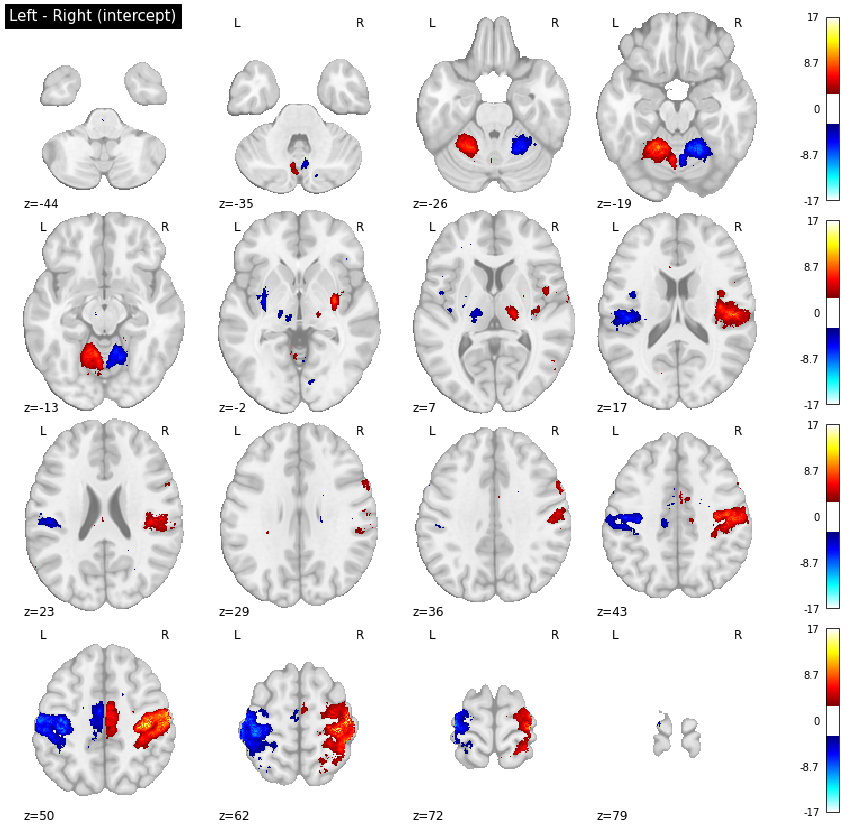

In [8]:
z_map_responselr_intercept, threshold = get_second_level_zmap('left-right', 'intercept', thresholding='fdr',model_n=1,from_working_dir=False, flame='12')
f, ax = plot_4x4(z_map_responselr_intercept, threshold=threshold, bg_img=mni09c, title='Left - Right (intercept)', black_bg=False)

## FS-Go

In [7]:
z_map_responselr_intercept, threshold = get_second_level_zmap('fs-go', 'intercept', thresholding='fdr',model_n=0,from_working_dir=False, flame='12')
f, ax = plot_4x4(z_map_responselr_intercept, threshold=threshold, bg_img=mni09c, title='FS - Go (intercept)')

FileNotFoundError: No such file or no access: '../derivatives/glm_feat_hp_sct/group_level_model/ses-sstmsit/task-sst/model-0/model-0/model-0/model-0_fwhm-1p5_subjectlevelcontrast-3_grouplevelcontrast-1_flame-12_desc-zstat.nii.gz'

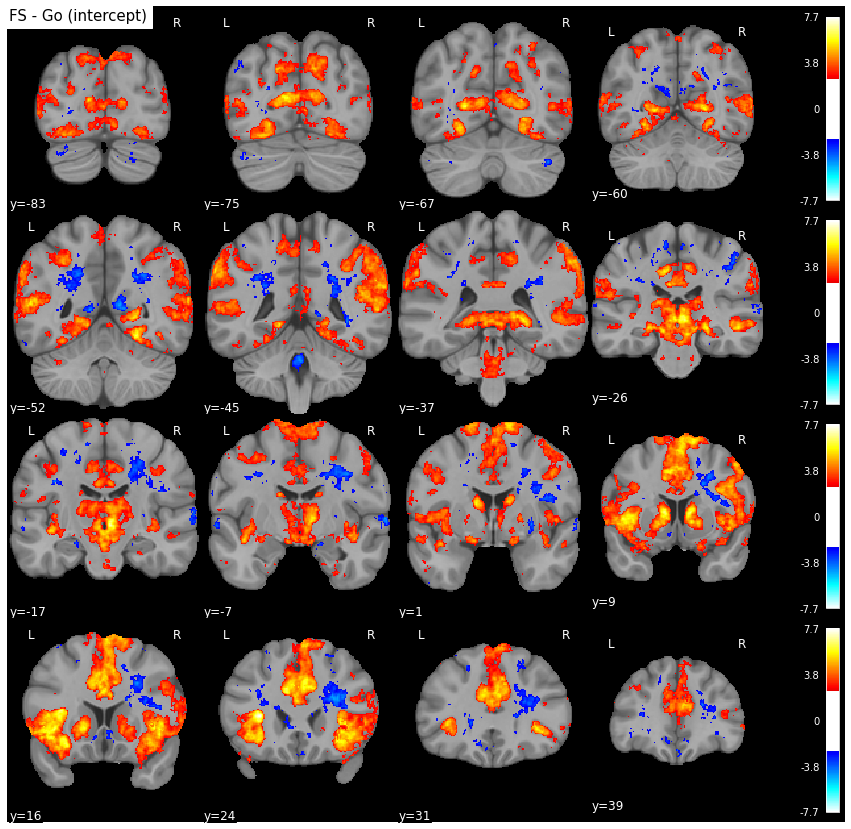

In [54]:
z_map_responselr_intercept, threshold = get_second_level_zmap('fs-go', 'intercept', thresholding='fdr',model_n=0,from_working_dir=False, flame='1')
f, ax = plot_4x4(z_map_responselr_intercept, threshold=threshold, display_mode='y', bg_img=mni09c, title='FS - Go (intercept)')

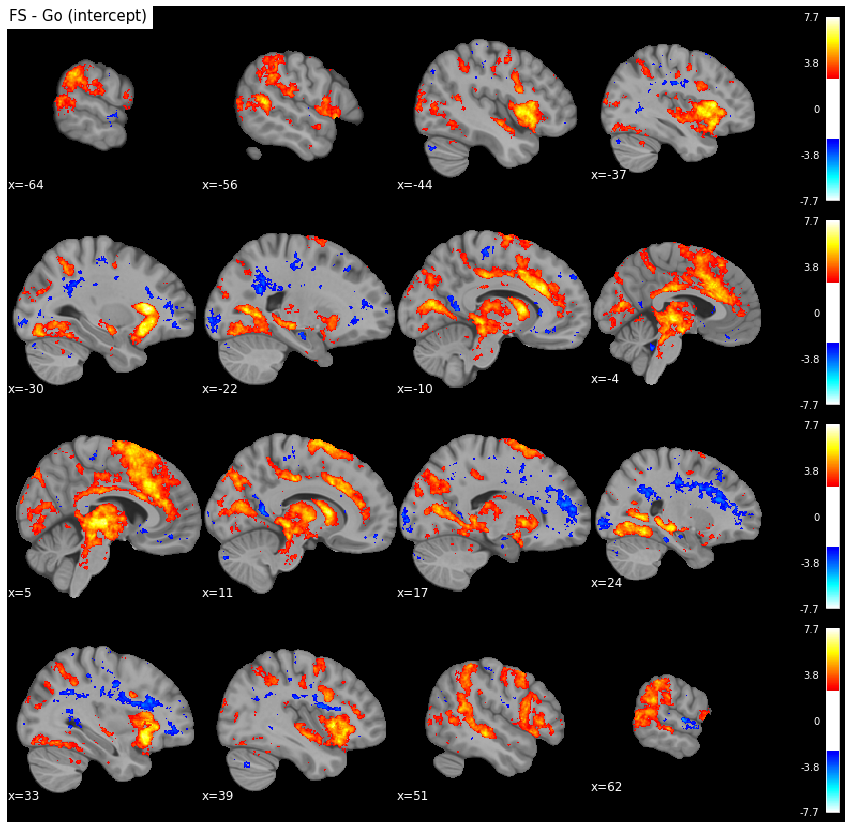

In [55]:
z_map_responselr_intercept, threshold = get_second_level_zmap('fs-go', 'intercept', thresholding='fdr')
f, ax = plot_4x4(z_map_responselr_intercept, display_mode = 'x', threshold=threshold, bg_img=mni09c, title='FS - Go (intercept)')

# FS - SS

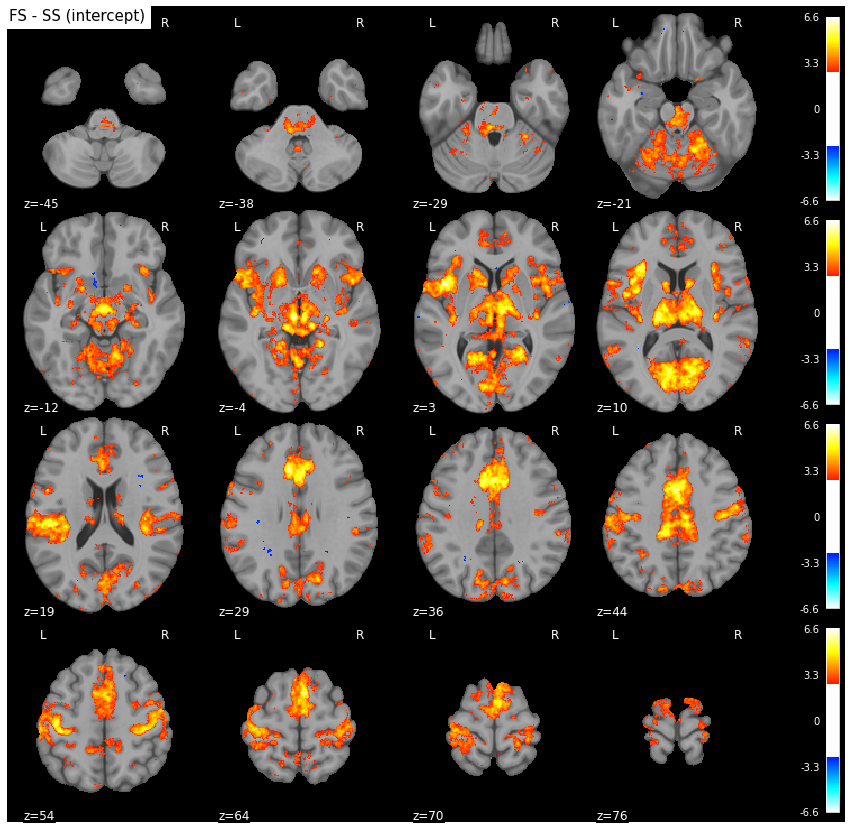

In [56]:
z_map_responselr_intercept, threshold = get_second_level_zmap('fs-ss', 'intercept', thresholding='fdr')
f, ax = plot_4x4(z_map_responselr_intercept, display_mode = 'z', threshold=threshold, bg_img=mni09c, title='FS - SS (intercept)')

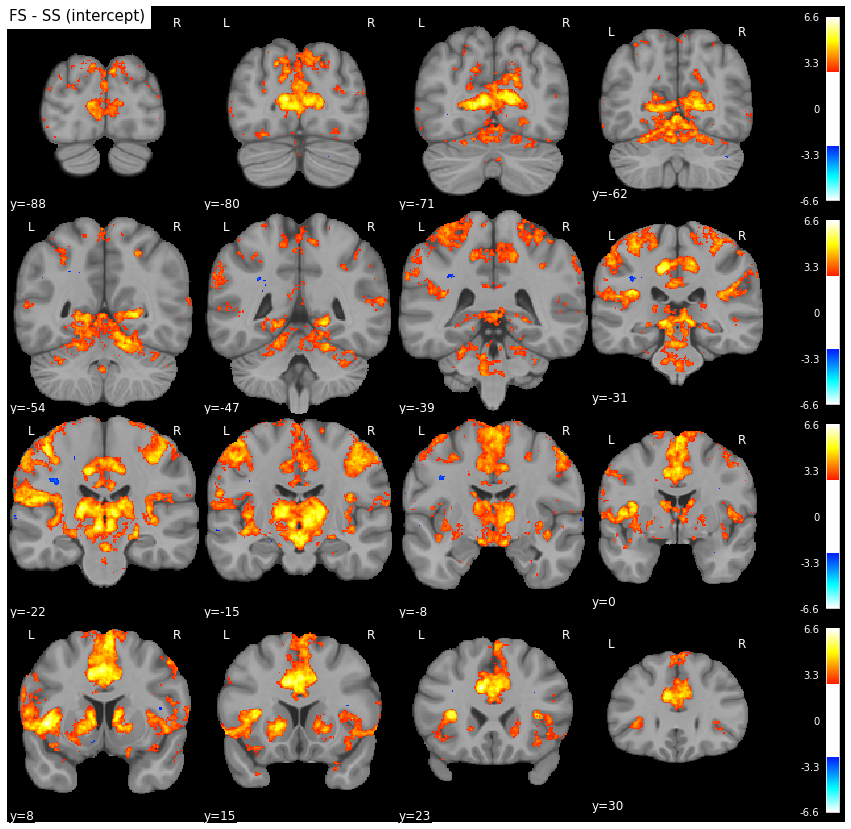

In [57]:
z_map_responselr_intercept, threshold = get_second_level_zmap('fs-ss', 'intercept', thresholding='fdr')
f, ax = plot_4x4(z_map_responselr_intercept, display_mode = 'y', threshold=threshold, bg_img=mni09c, title='FS - SS (intercept)')

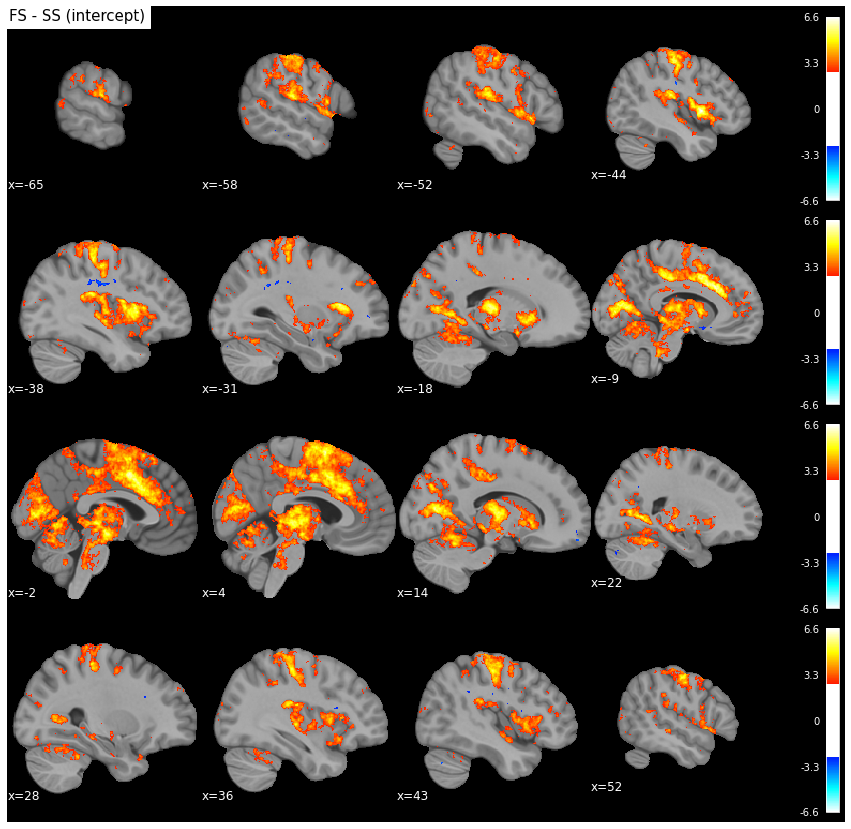

In [58]:
z_map_responselr_intercept, threshold = get_second_level_zmap('fs-ss', 'intercept', thresholding='fdr')
f, ax = plot_4x4(z_map_responselr_intercept, display_mode = 'x', threshold=threshold, bg_img=mni09c, title='FS - SS (intercept)')

## SS - Go

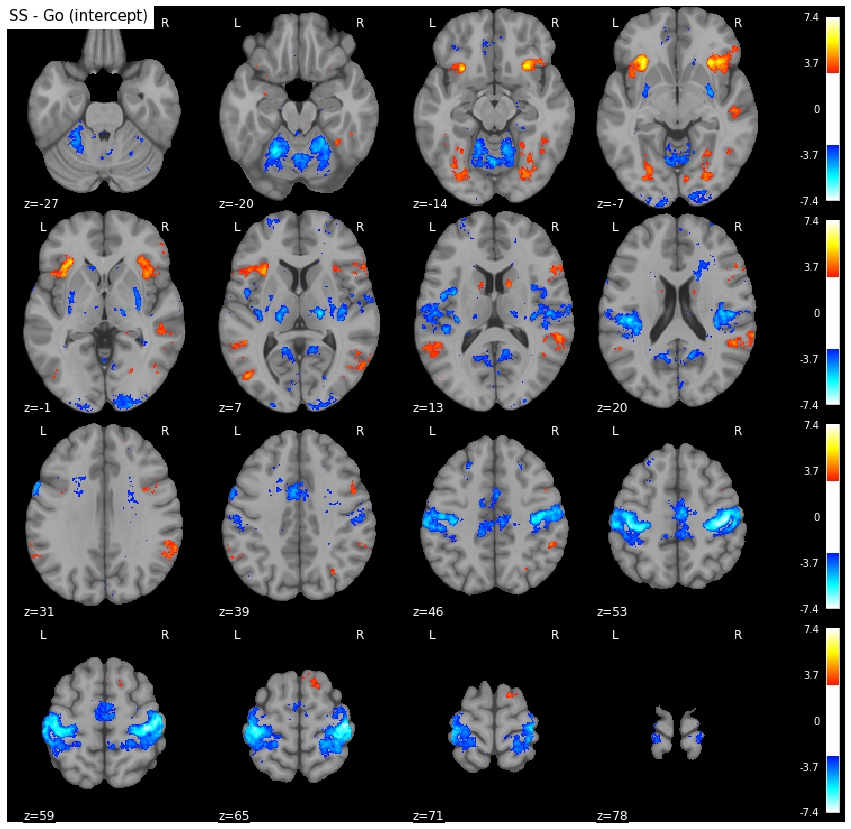

In [59]:
z_map_responselr_intercept, threshold = get_second_level_zmap('ss-go', 'intercept', thresholding='fdr',model_n=0,from_working_dir=False, flame='1')
f, ax = plot_4x4(z_map_responselr_intercept, threshold=threshold, display_mode='z', bg_img=mni09c, title='SS - Go (intercept)')

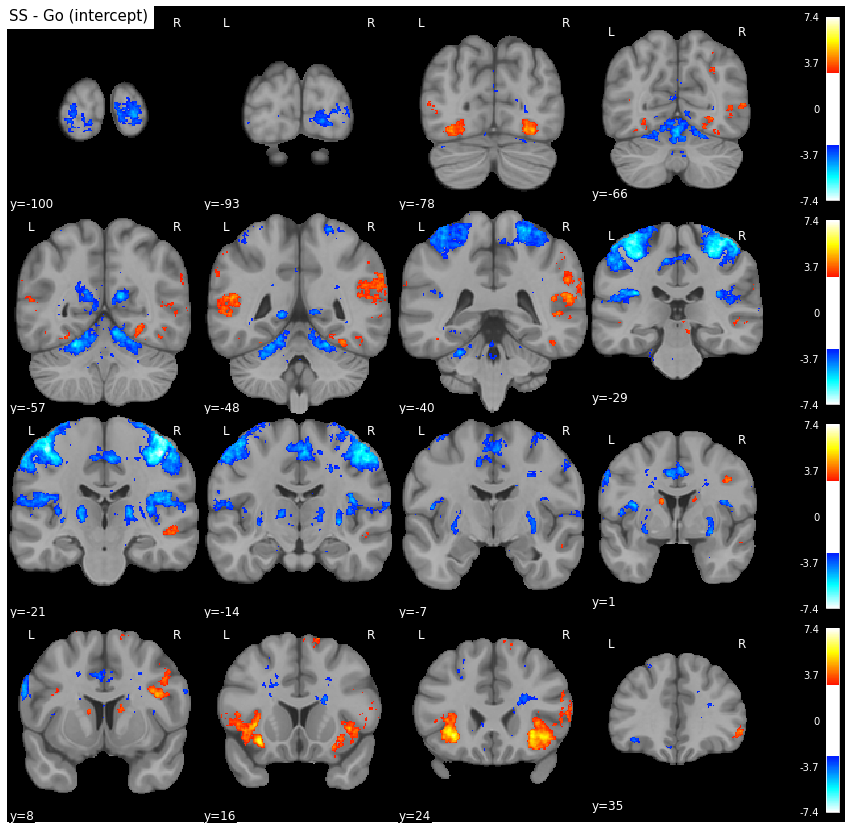

In [60]:
z_map_responselr_intercept, threshold = get_second_level_zmap('ss-go', 'intercept', thresholding='fdr',model_n=0,from_working_dir=False, flame='1')
f, ax = plot_4x4(z_map_responselr_intercept, threshold=threshold, display_mode='y', bg_img=mni09c, title='SS - Go (intercept)')

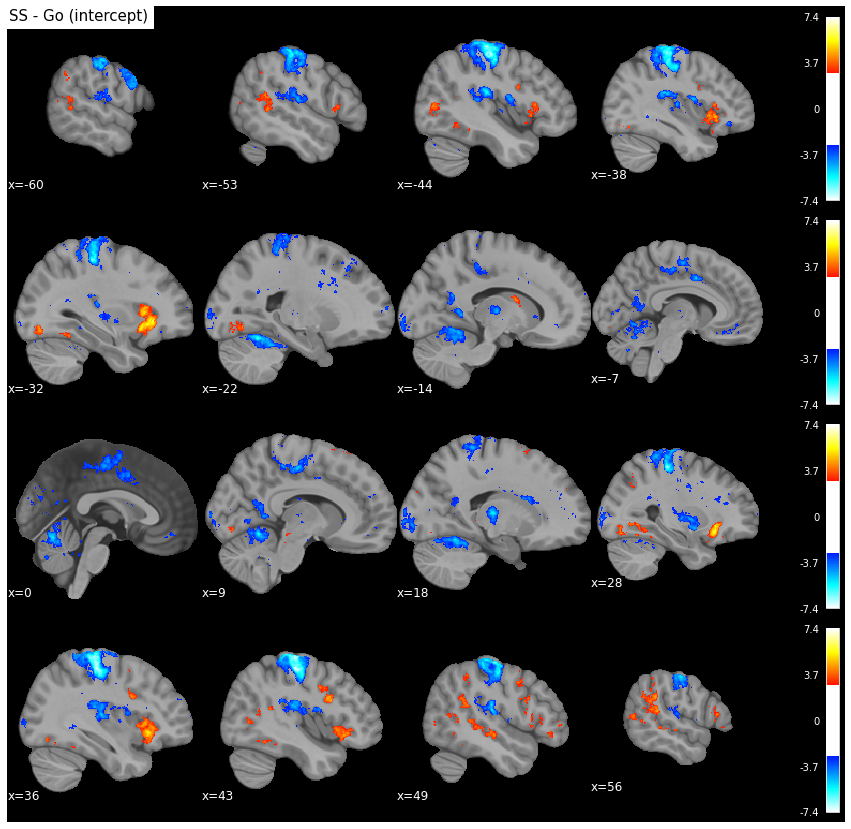

In [61]:
z_map_responselr_intercept, threshold = get_second_level_zmap('ss-go', 'intercept', thresholding='fdr',model_n=0,from_working_dir=False, flame='1')
f, ax = plot_4x4(z_map_responselr_intercept, threshold=threshold, display_mode='x', bg_img=mni09c, title='SS - Go (intercept)')

# plot all contrasts

In [63]:
# def get_roi_dict():
#     # make dict of masks & filenames in 09c-space, get colors
#     fns = glob.glob('/home/Public/trondheim/sourcedata/masks/MNI152NLin2009cAsym_res-1p5/space-MNI152NLin2009cAsym_res-*') # find all masks at 1p5 resolution
#     fns.sort()
#     names = [re.match('.*space-(?P<space>[a-zA-Z0-9]+)_res-1p5_label-(?P<label>[a-zA-Z0-9]+)_probseg_def-img.nii.gz', fn).groupdict()['label'] for fn in fns]
#     roi_dict = dict(zip(names, fns))
#     for mask, fn in roi_dict.items():
#         roi_dict[mask] = {}
#         roi_dict[mask]['fn'] = fn
#         roi_dict[mask]['color'] = get_color(mask)
#         roi_dict[mask]['threshold'] = 0.3
#     return roi_dict

In [27]:
zmap_fsgo.get_fdata().max()

10.713713645935059

In [ ]:
glob.glob('../derivatives/glm_feat_hp_sct/group_level_model/ses-sstmsit/task-sst/model-0/')

In [5]:
# Load MNI template
# Make background colour black
mni09c_load = nib.load(mni09c)
black_bg = mni09c_load.get_data()
black_bg[black_bg>0] = 0
black_bg = nib.Nifti1Image(black_bg, affine=mni09c_load.affine)

# zmap_fsgo, thresh = get_second_level_zmap('fs-go', 'intercept', thresholding='fdr')
# zmap_ssgo, thresh = get_second_level_zmap('ss-go', 'intercept', thresholding='fdr')
# zmap_fsss, thresh = get_second_level_zmap('fs-ss', 'intercept', thresholding='fdr')

zmap_fsgo, thresh1 = get_second_level_zmap('fs-go', 'intercept', thresholding='fdr',model_n=0,from_working_dir=False, flame='12')
zmap_ssgo, thresh2 = get_second_level_zmap('ss-go', 'intercept', thresholding='fdr',model_n=0,from_working_dir=False, flame='12')
zmap_fsss, thresh3 = get_second_level_zmap('fs-ss', 'intercept', thresholding='fdr',model_n=0,from_working_dir=False, flame='12')


zmaps = [zmap_fsgo, zmap_ssgo, zmap_fsss]
thresh = [thresh1,thresh2,thresh3]

/tmp/ipykernel_3056711/2144011477.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  black_bg = mni09c_load.get_data()


Text(0.5, 1.0, 'z-value')

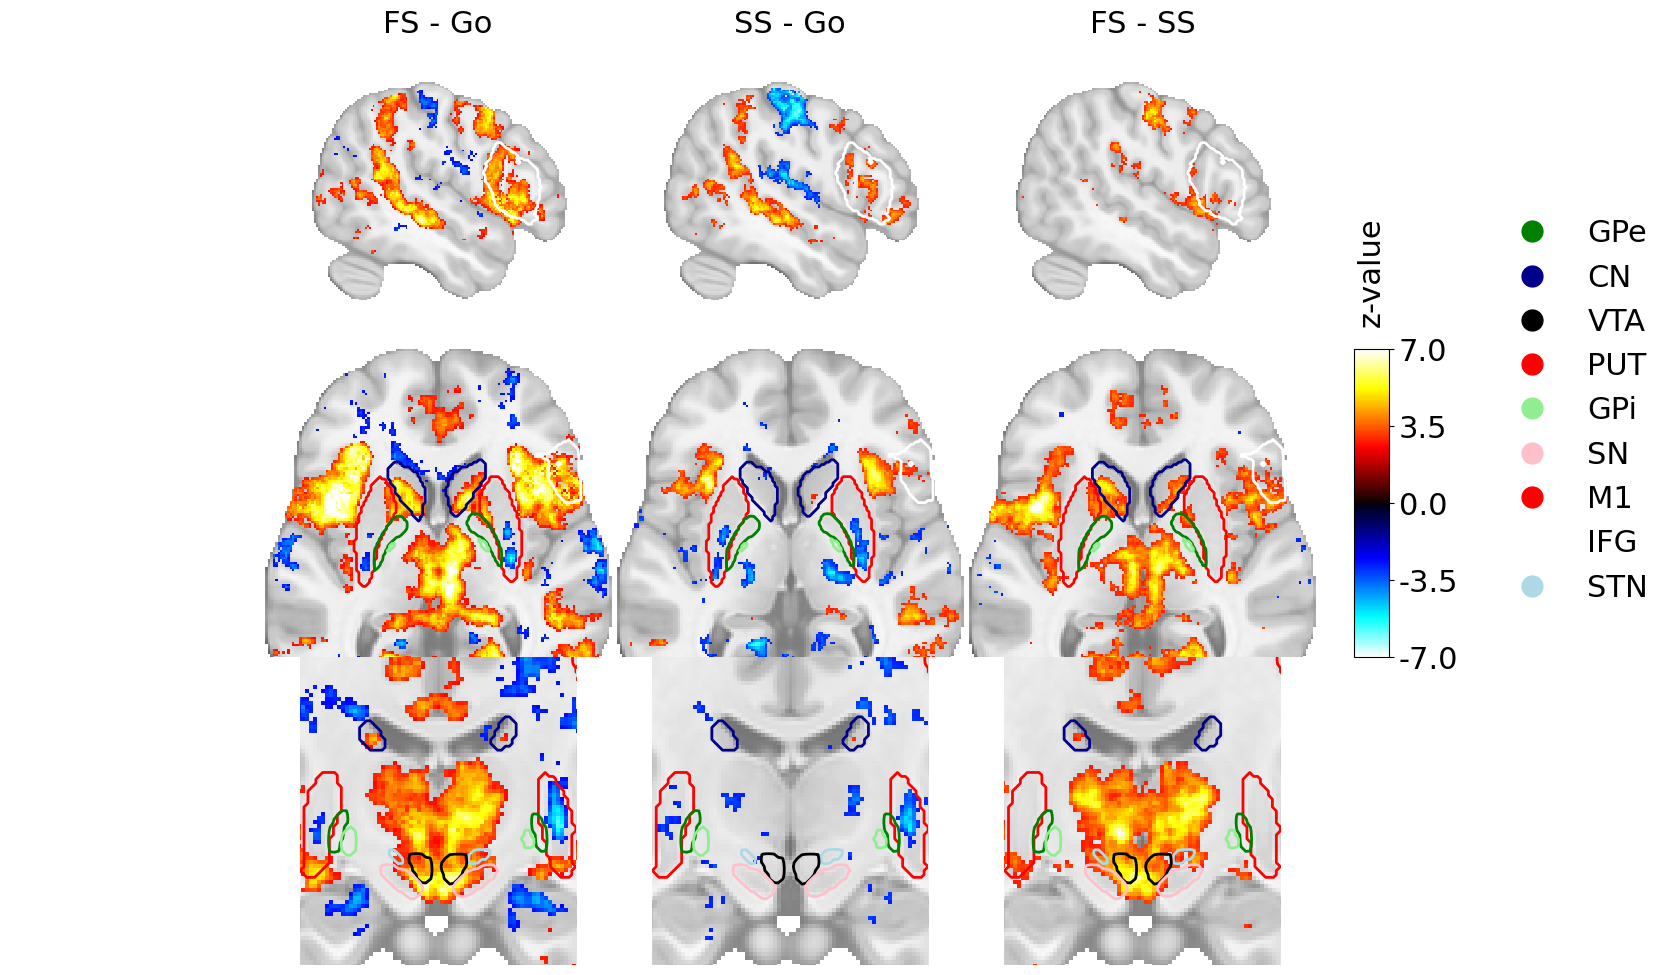

In [7]:
# plot t maps for smoothed images
fontsize = 22
vmax = 7
import matplotlib
font = {'family' : 'normal',
        'weight': 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)
matplotlib.rc('axes', titlesize=fontsize)

from matplotlib import gridspec
gridspec_kws = dict(hspace=0.0, wspace=0.0, 
                width_ratios=[1] * len(zmaps) + [.1, .1, .1])
gs = gridspec.GridSpec(3, len(zmaps)+3, **gridspec_kws)
f, axes = plt.subplots(3, len(zmaps)+3, gridspec_kw=gridspec_kws)  
# add 5 columns: 3 interspaces, 2 colorbars

f, axes, disps = plot_spm(zmaps, 
                          roi_dict=get_roi_dict(),
                          z_threshold=thresh,
                          f=f, axes=axes,
                          roi_to_plot=['rIFG', 'STR', 'STN'],
                          cut_coords=[[51], [2], [-13]],
                          bg_img=mni09c,
                          vmax=vmax, #colorbar=False, 
                          plot_columns=(0, 1, 2, 3, 4),
                          annotate=False, empty_plots=False, black_bg=False,
                          skip_all_but_last=False)
axes[0,0].set_title('FS - Go')
axes[0,1].set_title('SS - Go')
axes[0,2].set_title('FS - SS')
#axes[0,3].set_title('20')

for row in range(axes.shape[0]):
#     axes[row,2].set_visible(False)
#     axes[row,5].set_visible(False)
#     axes[row,8].set_visible(False)
    if row in [0,1,2]:
        for col in [-3,-2,-1]:
            axes[row,col].set_visible(False)
            axes[row,col].set_visible(False)

# Adjust positions of y labels
axes[0,0].set_ylabel('x = 51', labelpad=-24)
axes[1,0].set_ylabel('y = 2', labelpad=-24)
axes[2,0].set_ylabel('z = -13', labelpad=-24)

# colormap legend
cbar_ax1 = f.add_subplot(gs[1,-2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=cbar_ax1, vmin=-vmax,
                                vmax=vmax, truncation_limits=(-vmax,vmax), offset=0, flip=False, nb_ticks=5, format="%.1f")
cbar_ax1.yaxis.set_ticks_position('right')
cbar_ax1.set_title('z-value', rotation=90, ha='center', va='bottom', pad=16)

# f.savefig('../derivatives/glm_feat/plots/ses-sstmsit/group_level_fs-go_1p5.pdf')

Text(0.5, 1.0, 'z-value')

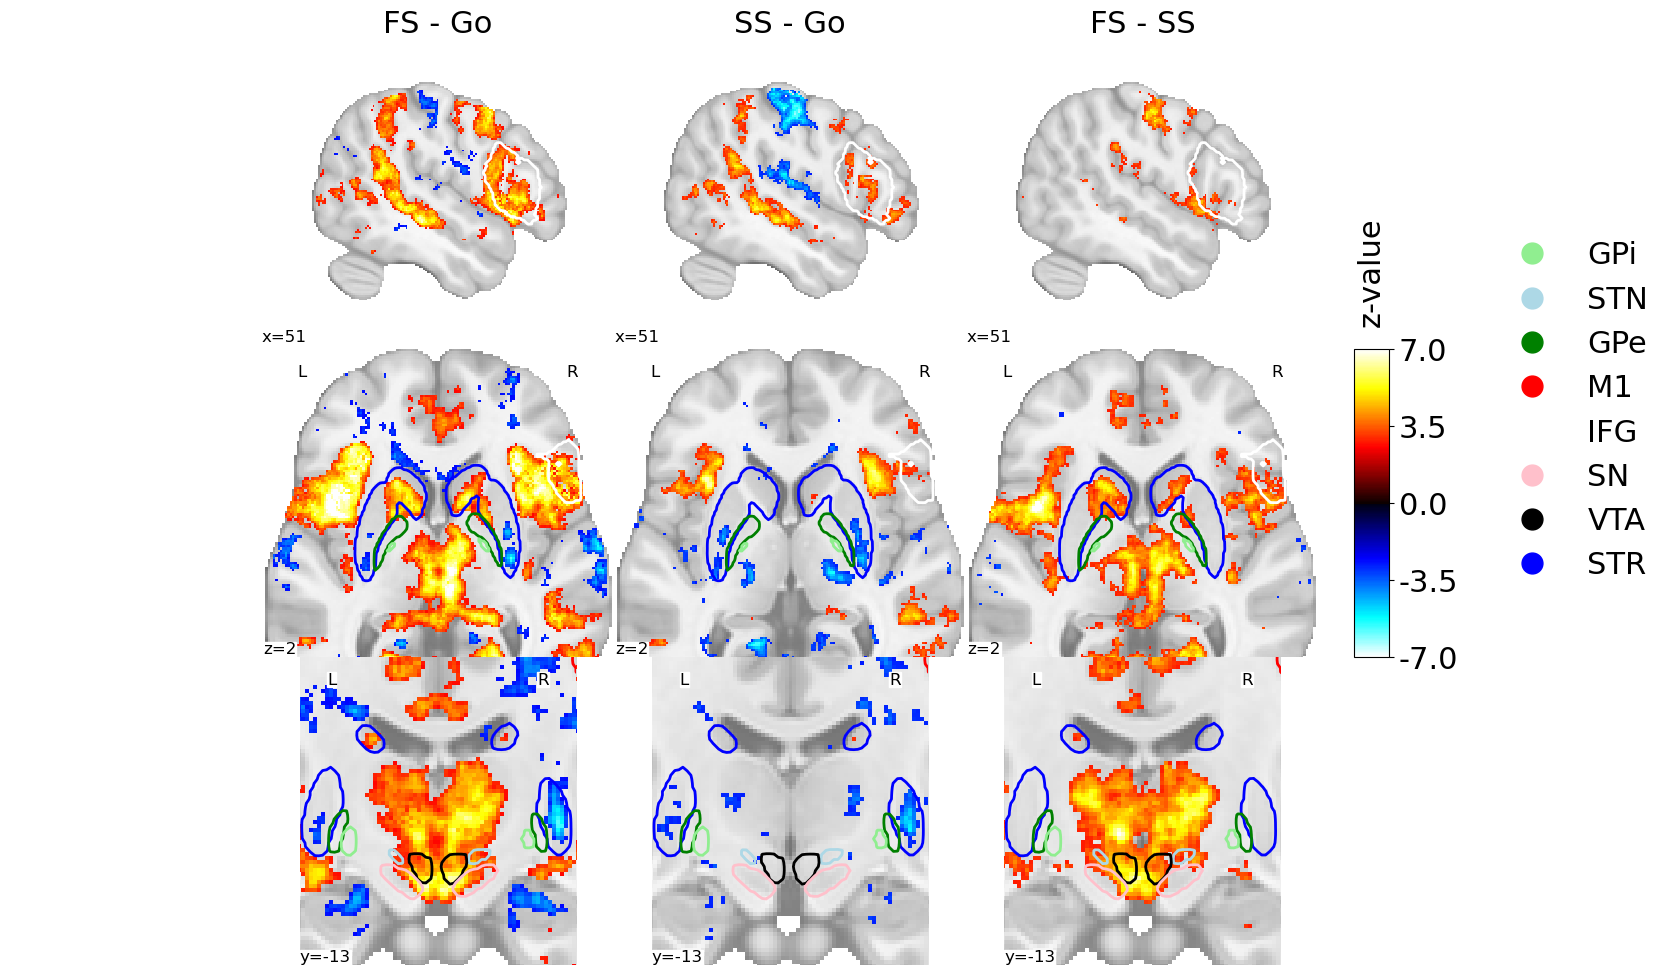

In [9]:
# plot t maps for smoothed images
fontsize = 22
vmax = 7
import matplotlib
font = {'family' : 'normal',
        'weight': 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)
matplotlib.rc('axes', titlesize=fontsize)

from matplotlib import gridspec
gridspec_kws = dict(hspace=0.0, wspace=0.0, 
                width_ratios=[1] * len(zmaps) + [.1, .1, .1])
gs = gridspec.GridSpec(3, len(zmaps)+3, **gridspec_kws)
f, axes = plt.subplots(3, len(zmaps)+3, gridspec_kw=gridspec_kws)  
# add 5 columns: 3 interspaces, 2 colorbars

f, axes, disps = plot_spm(zmaps, 
                          roi_dict=get_roi_dict(),
                          z_threshold=thresh,
                          f=f, axes=axes,
                          roi_to_plot=['rIFG', 'STR', 'STN'],
                          cut_coords=[[51], [2], [-13]],
                          bg_img=mni09c,
                          vmax=vmax, #colorbar=False, 
                          plot_columns=(0, 1, 2, 3, 4),
                          annotate=True, empty_plots=False, black_bg=False,
                          skip_all_but_last=False)
axes[0,0].set_title('FS - Go')
axes[0,1].set_title('SS - Go')
axes[0,2].set_title('FS - SS')
#axes[0,3].set_title('20')

for row in range(axes.shape[0]):
#     axes[row,2].set_visible(False)
#     axes[row,5].set_visible(False)
#     axes[row,8].set_visible(False)
    if row in [0,1,2]:
        for col in [-3,-2,-1]:
            axes[row,col].set_visible(False)
            axes[row,col].set_visible(False)

# Adjust positions of y labels
axes[0,0].set_ylabel('x = 51', labelpad=-24)
axes[1,0].set_ylabel('y = 2', labelpad=-24)
axes[2,0].set_ylabel('z = -13', labelpad=-24)

# colormap legend
cbar_ax1 = f.add_subplot(gs[1,-2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=cbar_ax1, vmin=-vmax,
                                vmax=vmax, truncation_limits=(-vmax,vmax), offset=0, flip=False, nb_ticks=5, format="%.1f")
cbar_ax1.yaxis.set_ticks_position('right')
cbar_ax1.set_title('z-value', rotation=90, ha='center', va='bottom', pad=16)

# f.savefig('../derivatives/glm_feat/plots/ses-sstmsit/group_level_fs-go_1p5.pdf')

/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),


Text(0.5, 1.0, 'z-value')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


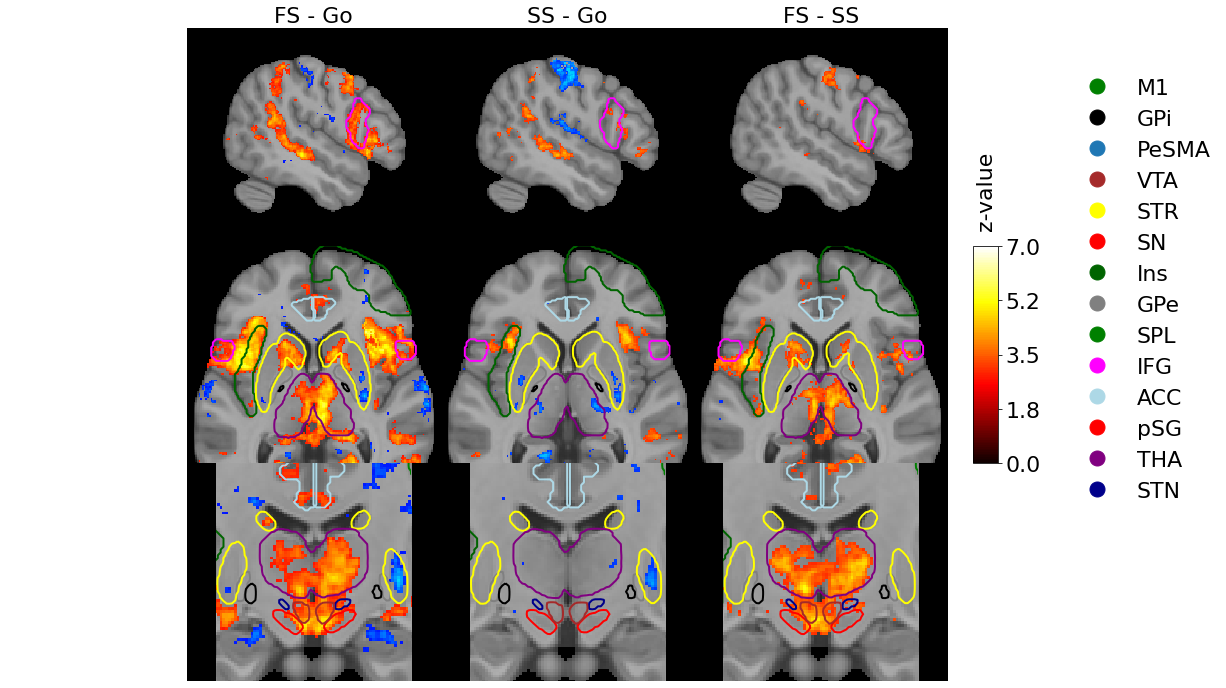

In [10]:
# plot t maps for smoothed images
fontsize = 22
vmax = 7
import matplotlib
font = {'family' : 'normal',
        'weight': 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)
matplotlib.rc('axes', titlesize=fontsize)

from matplotlib import gridspec
gridspec_kws = dict(hspace=0.0, wspace=0.0, 
                width_ratios=[1] * len(zmaps) + [.1, .1, .1])
gs = gridspec.GridSpec(3, len(zmaps)+3, **gridspec_kws)
f, axes = plt.subplots(3, len(zmaps)+3, gridspec_kw=gridspec_kws)  
# add 5 columns: 3 interspaces, 2 colorbars

f, axes, disps = plot_spm(zmaps, 
                          roi_dict=get_roi_dict(),
                          z_threshold=thresh,
                          f=f, axes=axes,
                          roi_to_plot=['rIFG', 'STR', 'STN'],
                          cut_coords=[[51], [2], [-13]],
                          bg_img=mni09c,
                          vmax=vmax, #colorbar=False, 
                          plot_columns=(0, 1, 2, 3, 4),
                          annotate=False, empty_plots=False, 
                          skip_all_but_last=False)
axes[0,0].set_title('FS - Go')
axes[0,1].set_title('SS - Go')
axes[0,2].set_title('FS - SS')
#axes[0,3].set_title('20')

for row in range(axes.shape[0]):
#     axes[row,2].set_visible(False)
#     axes[row,5].set_visible(False)
#     axes[row,8].set_visible(False)
    if row in [0,1,2]:
        for col in [-3,-2,-1]:
            axes[row,col].set_visible(False)
            axes[row,col].set_visible(False)

# Adjust positions of y labels
axes[0,0].set_ylabel('x = 51', labelpad=-24)
axes[1,0].set_ylabel('y = 2', labelpad=-24)
axes[2,0].set_ylabel('z = -13', labelpad=-24)

# colormap legend
cbar_ax1 = f.add_subplot(gs[1,-2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=cbar_ax1, vmin=0,
                                vmax=vmax, truncation_limits=(0,vmax), offset=0, flip=False, nb_ticks=5, format="%.1f")
cbar_ax1.yaxis.set_ticks_position('right')
cbar_ax1.set_title('z-value', rotation=90, ha='center', va='bottom', pad=16)

# f.savefig('../derivatives/glm_feat/plots/ses-sstmsit/group_level_fs-go_1p5.pdf')

Text(0.5, 1.0, 'z-value')

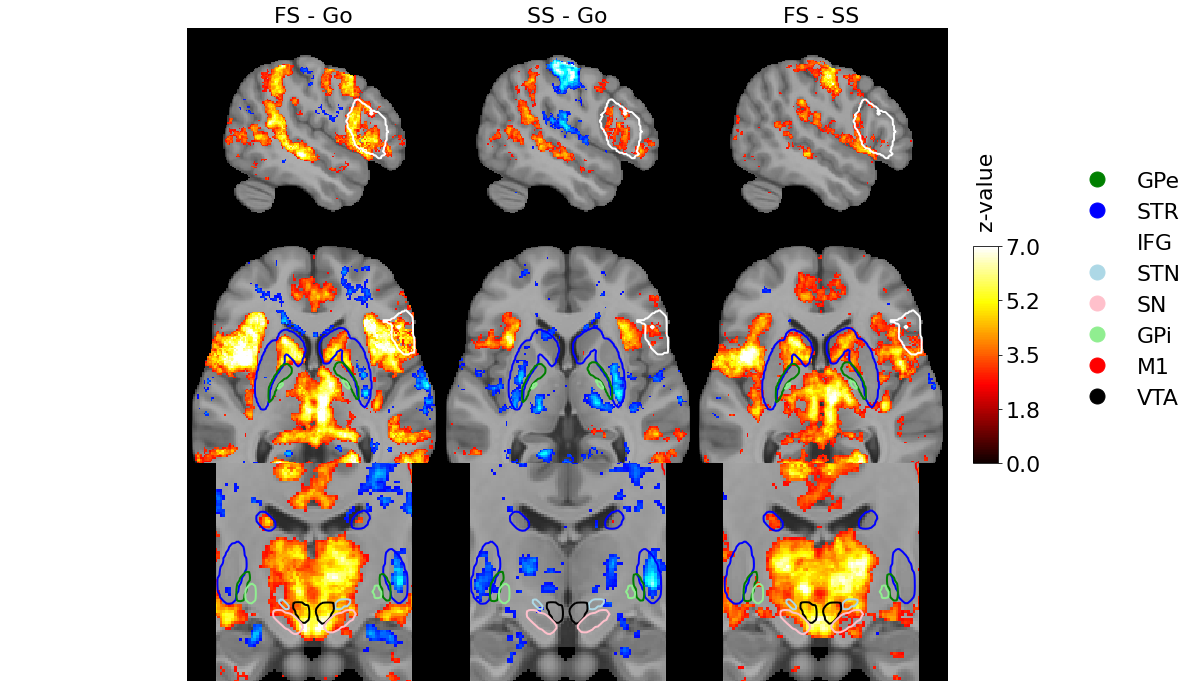

In [29]:
# plot t maps for smoothed images
fontsize = 22
vmax = 7
import matplotlib
font = {'family' : 'normal',
        'weight': 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)
matplotlib.rc('axes', titlesize=fontsize)

from matplotlib import gridspec
gridspec_kws = dict(hspace=0.0, wspace=0.0, 
                width_ratios=[1] * len(zmaps) + [.1, .1, .1])
gs = gridspec.GridSpec(3, len(zmaps)+3, **gridspec_kws)
f, axes = plt.subplots(3, len(zmaps)+3, gridspec_kw=gridspec_kws)  
# add 5 columns: 3 interspaces, 2 colorbars

f, axes, disps = plot_spm(zmaps, 
                          roi_dict=get_roi_dict(),
                          z_threshold=thresh,
                          f=f, axes=axes,
                          roi_to_plot=['rIFG', 'STR', 'STN'],
                          cut_coords=[[51], [2], [-13]],
                          bg_img=mni09c,
                          vmax=vmax, #colorbar=False, 
                          plot_columns=(0, 1, 2, 3, 4),
                          annotate=False, empty_plots=False, 
                          skip_all_but_last=False)
axes[0,0].set_title('FS - Go')
axes[0,1].set_title('SS - Go')
axes[0,2].set_title('FS - SS')
#axes[0,3].set_title('20')

for row in range(axes.shape[0]):
#     axes[row,2].set_visible(False)
#     axes[row,5].set_visible(False)
#     axes[row,8].set_visible(False)
    if row in [0,1,2]:
        for col in [-3,-2,-1]:
            axes[row,col].set_visible(False)
            axes[row,col].set_visible(False)

# Adjust positions of y labels
axes[0,0].set_ylabel('x = 51', labelpad=-24)
axes[1,0].set_ylabel('y = 2', labelpad=-24)
axes[2,0].set_ylabel('z = -13', labelpad=-24)

# colormap legend
cbar_ax1 = f.add_subplot(gs[1,-2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=cbar_ax1, vmin=0,
                                vmax=vmax, truncation_limits=(0,vmax), offset=0, flip=False, nb_ticks=5, format="%.1f")
cbar_ax1.yaxis.set_ticks_position('right')
cbar_ax1.set_title('z-value', rotation=90, ha='center', va='bottom', pad=16)

# f.savefig('../derivatives/glm_feat/plots/ses-sstmsit/group_level_fs-go_1p5.pdf')

# ALL CONTRASTS

In [8]:
# Load MNI template
# Make background colour black
mni09c_load = nib.load(mni09c)
black_bg = mni09c_load.get_data()
black_bg[black_bg>0] = 0
black_bg = nib.Nifti1Image(black_bg, affine=mni09c_load.affine)

zmap_fs, thresh = get_second_level_zmap('fs', 'intercept', thresholding='fdr')
zmap_go, thresh = get_second_level_zmap('go', 'intercept', thresholding='fdr')
zmap_ss, thresh = get_second_level_zmap('ss', 'intercept', thresholding='fdr')

zmaps = [zmap_fs, zmap_ss, zmap_go]

<ipython-input-8-6e3f0711e71a>:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  black_bg = mni09c_load.get_data()


../derivatives/glm_feat/group_level_model/ses-sstmsit/task-sst/third_level_model/level3_zstats/_contrast_n_0_fwhm_1p5_model_n_0/zstat1.nii.gz
../derivatives/glm_feat/group_level_model/ses-sstmsit/task-sst/third_level_model/level3_zstats/_contrast_n_2_fwhm_1p5_model_n_0/zstat1.nii.gz
../derivatives/glm_feat/group_level_model/ses-sstmsit/task-sst/third_level_model/level3_zstats/_contrast_n_1_fwhm_1p5_model_n_0/zstat1.nii.gz


/home/scotti/.conda/envs/py38/lib/python3.8/site-packages/nilearn/plotting/displays.py:97: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),


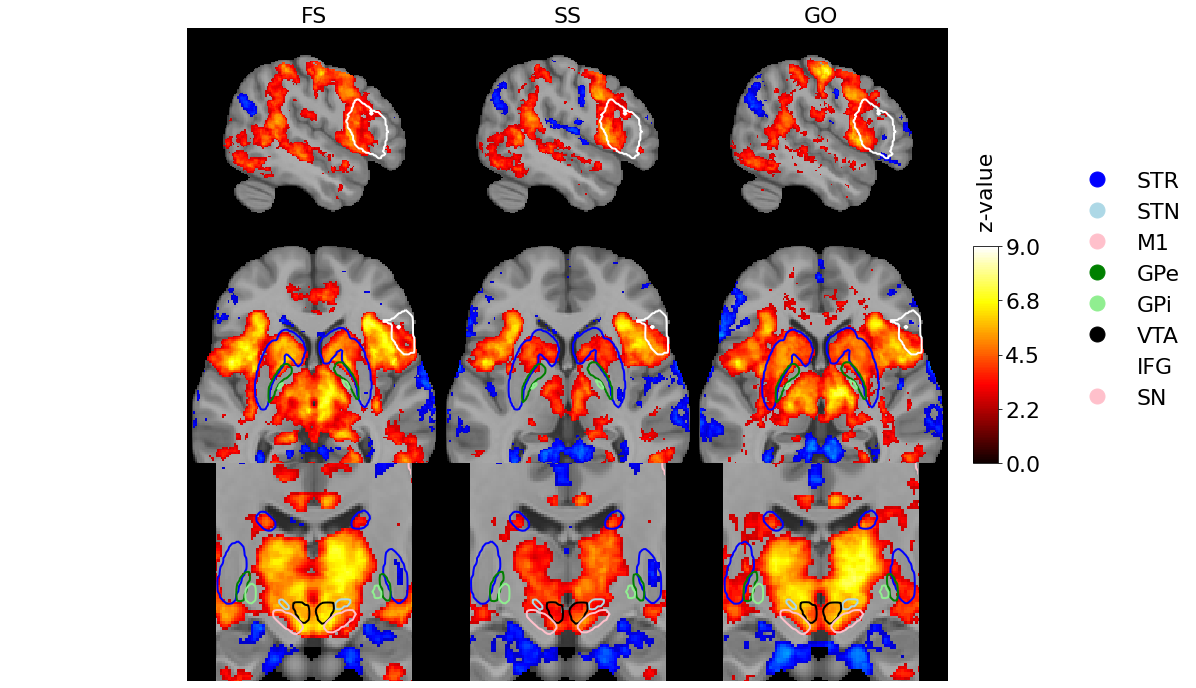

In [11]:
# plot t maps for smoothed images
fontsize = 22
vmax = 9
import matplotlib
font = {'family' : 'normal',
        'weight': 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)
matplotlib.rc('axes', titlesize=fontsize)

from matplotlib import gridspec
gridspec_kws = dict(hspace=0.0, wspace=0.0, 
                width_ratios=[1] * len(zmaps) + [.1, .1, .1])
gs = gridspec.GridSpec(3, len(zmaps)+3, **gridspec_kws)
f, axes = plt.subplots(3, len(zmaps)+3, gridspec_kw=gridspec_kws)  
# add 5 columns: 3 interspaces, 2 colorbars

f, axes, disps = plot_spm(zmaps, 
                          roi_dict=get_roi_dict(),
                          z_threshold=thresh,
                          f=f, axes=axes,
                          roi_to_plot=['rIFG', 'STR', 'STN'],
                          cut_coords=[[51], [2], [-13]],
                          bg_img=mni09c,
                          vmax=vmax, #colorbar=False, 
                          plot_columns=(0, 1, 2, 3, 4),
                          annotate=False, empty_plots=False, 
                          skip_all_but_last=False)
axes[0,0].set_title('FS')
axes[0,1].set_title('SS')
axes[0,2].set_title('GO')
#axes[0,3].set_title('20')

for row in range(axes.shape[0]):
#     axes[row,2].set_visible(False)
#     axes[row,5].set_visible(False)
#     axes[row,8].set_visible(False)
    if row in [0,1,2]:
        for col in [-3,-2,-1]:
            axes[row,col].set_visible(False)
            axes[row,col].set_visible(False)

# Adjust positions of y labels
axes[0,0].set_ylabel('x = 51', labelpad=-24)
axes[1,0].set_ylabel('y = 2', labelpad=-24)
axes[2,0].set_ylabel('z = -13', labelpad=-24)

# colormap legend
cbar_ax1 = f.add_subplot(gs[1,-2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=cbar_ax1, vmin=0,
                                vmax=vmax, truncation_limits=(0,vmax), offset=0, flip=False, nb_ticks=5, format="%.1f")
cbar_ax1.yaxis.set_ticks_position('right')
cbar_ax1.set_title('z-value', rotation=90, ha='center', va='bottom', pad=16)

f.savefig('../derivatives/glm_feat/plots/ses-sstmsit/group_level_all-conditions_1p5.pdf')

Text(0.5, 1.0, 'z-value')

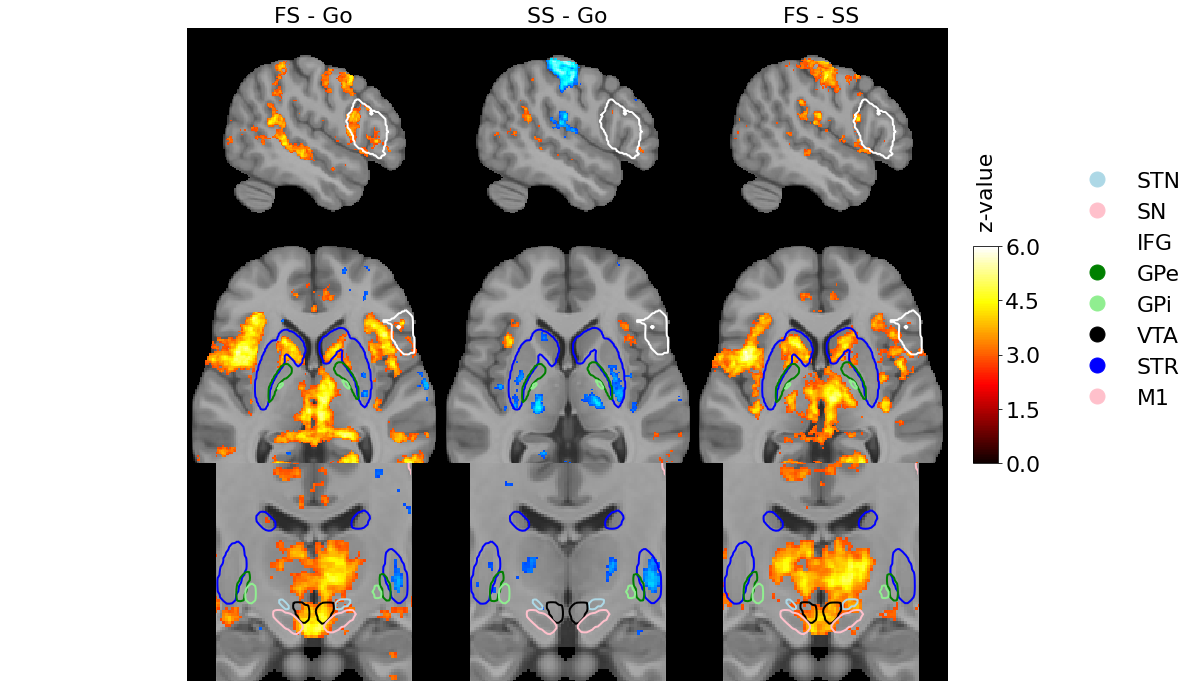

In [8]:
# plot t maps for smoothed images
fontsize = 22
vmax = 6
import matplotlib
font = {'family' : 'normal',
        'weight': 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)
matplotlib.rc('axes', titlesize=fontsize)

from matplotlib import gridspec
gridspec_kws = dict(hspace=0.0, wspace=0.0, 
                width_ratios=[1] * len(zmaps) + [.1, .1, .1])
gs = gridspec.GridSpec(3, len(zmaps)+3, **gridspec_kws)
f, axes = plt.subplots(3, len(zmaps)+3, gridspec_kw=gridspec_kws)  
# add 5 columns: 3 interspaces, 2 colorbars

f, axes, disps = plot_spm(zmaps, 
                          roi_dict=get_roi_dict(),
                          z_threshold=thresh,
                          f=f, axes=axes,
                          roi_to_plot=['rIFG', 'STR', 'STN'],
                          cut_coords=[[51], [2], [-13]],
                          bg_img=mni09c,
                          vmax=vmax, #colorbar=False, 
                          plot_columns=(0, 1, 2, 3, 4),
                          annotate=False, empty_plots=False, 
                          skip_all_but_last=False)
axes[0,0].set_title('FS - Go')
axes[0,1].set_title('SS - Go')
axes[0,2].set_title('FS - SS')
#axes[0,3].set_title('20')

for row in range(axes.shape[0]):
#     axes[row,2].set_visible(False)
#     axes[row,5].set_visible(False)
#     axes[row,8].set_visible(False)
    if row in [0,1,2]:
        for col in [-3,-2,-1]:
            axes[row,col].set_visible(False)
            axes[row,col].set_visible(False)

# Adjust positions of y labels
axes[0,0].set_ylabel('x = 51', labelpad=-24)
axes[1,0].set_ylabel('y = 2', labelpad=-24)
axes[2,0].set_ylabel('z = -13', labelpad=-24)

# colormap legend
cbar_ax1 = f.add_subplot(gs[1,-2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=cbar_ax1, vmin=0,
                                vmax=vmax, truncation_limits=(0,vmax), offset=0, flip=False, nb_ticks=5, format="%.1f")
cbar_ax1.yaxis.set_ticks_position('right')
cbar_ax1.set_title('z-value', rotation=90, ha='center', va='bottom', pad=16)

/home/scotti/.conda/envs/py38/lib/python3.8/site-packages/nilearn/plotting/displays.py:97: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),


Text(0.5, 1.0, 'z-value')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


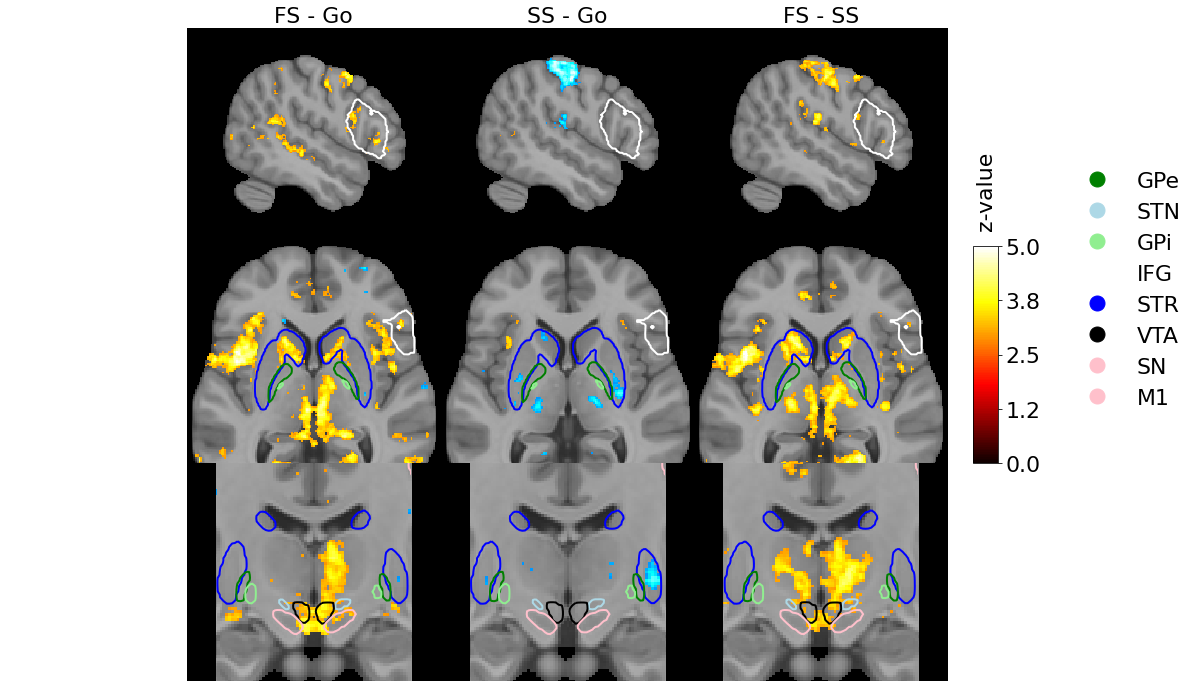

In [11]:
# plot t maps for smoothed images
fontsize = 22
vmax = 5
import matplotlib
font = {'family' : 'normal',
        'weight': 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)
matplotlib.rc('axes', titlesize=fontsize)

from matplotlib import gridspec
gridspec_kws = dict(hspace=0.0, wspace=0.0, 
                width_ratios=[1] * len(zmaps) + [.1, .1, .1])
gs = gridspec.GridSpec(3, len(zmaps)+3, **gridspec_kws)
f, axes = plt.subplots(3, len(zmaps)+3, gridspec_kw=gridspec_kws)  
# add 5 columns: 3 interspaces, 2 colorbars

f, axes, disps = plot_spm(zmaps, 
                          roi_dict=get_roi_dict(),
                          z_threshold=thresh,
                          f=f, axes=axes,
                          roi_to_plot=['rIFG', 'STR', 'STN'],
                          cut_coords=[[51], [2], [-13]],
                          bg_img=mni09c,
                          vmax=vmax, #colorbar=False, 
                          plot_columns=(0, 1, 2, 3, 4),
                          annotate=False, empty_plots=False, 
                          skip_all_but_last=False)
axes[0,0].set_title('FS - Go')
axes[0,1].set_title('SS - Go')
axes[0,2].set_title('FS - SS')
#axes[0,3].set_title('20')

for row in range(axes.shape[0]):
#     axes[row,2].set_visible(False)
#     axes[row,5].set_visible(False)
#     axes[row,8].set_visible(False)
    if row in [0,1,2]:
        for col in [-3,-2,-1]:
            axes[row,col].set_visible(False)
            axes[row,col].set_visible(False)

# Adjust positions of y labels
axes[0,0].set_ylabel('x = 51', labelpad=-24)
axes[1,0].set_ylabel('y = 2', labelpad=-24)
axes[2,0].set_ylabel('z = -13', labelpad=-24)

# colormap legend
cbar_ax1 = f.add_subplot(gs[1,-2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=cbar_ax1, vmin=0,
                                vmax=vmax, truncation_limits=(0,vmax), offset=0, flip=False, nb_ticks=5, format="%.1f")
cbar_ax1.yaxis.set_ticks_position('right')
cbar_ax1.set_title('z-value', rotation=90, ha='center', va='bottom', pad=16)

<ipython-input-27-03399d36eda9>:293: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data = map_img.get_data()


Text(0.5, 1.0, 't-value')

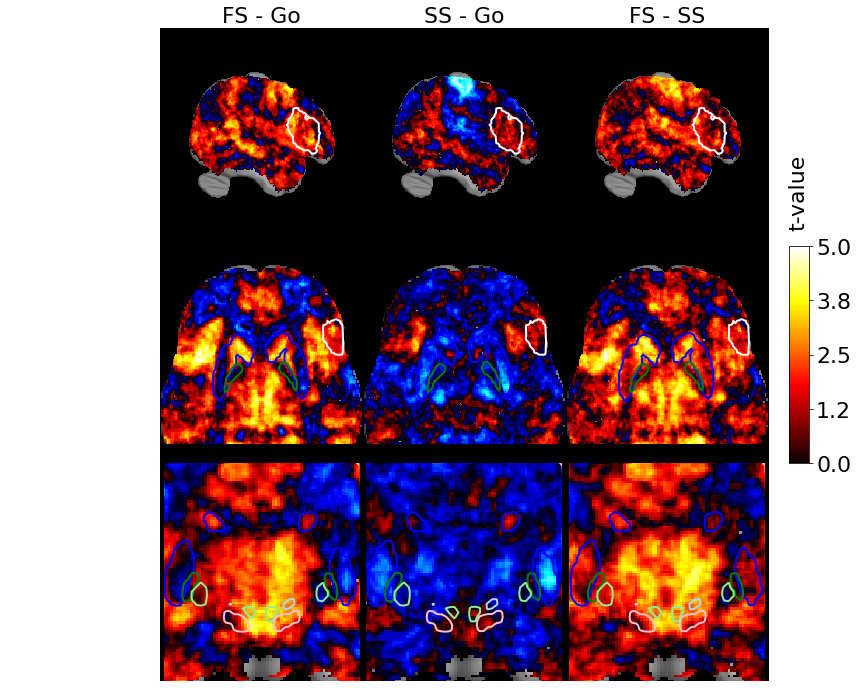

In [47]:
# plot t maps for smoothed images
fontsize = 22
vmax = 5
import matplotlib
font = {'family' : 'normal',
        'weight': 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)
matplotlib.rc('axes', titlesize=fontsize)

from matplotlib import gridspec
gridspec_kws = dict(hspace=0.0, wspace=0.0, 
                width_ratios=[1] * len(zmaps) + [.1, .1, .1])
gs = gridspec.GridSpec(3, len(zmaps)+3, **gridspec_kws)
f, axes = plt.subplots(3, len(zmaps)+3, gridspec_kw=gridspec_kws)  
# add 5 columns: 3 interspaces, 2 colorbars

f, axes, disps = plot_spm(zmaps, 
                          roi_dict=get_roi_dict(),
                          z_threshold=0.001,
                          f=f, axes=axes,
                          roi_to_plot=['rIFG', 'STR', 'STN'],
                          cut_coords=[[51], [2], [-13]],
                          bg_img=mni09c,
                          vmax=vmax, #colorbar=False, 
                          plot_columns=(0, 1, 2, 3, 4),
                          annotate=False, empty_plots=False, 
                          skip_all_but_last=False)
axes[0,0].set_title('FS - Go')
axes[0,1].set_title('SS - Go')
axes[0,2].set_title('FS - SS')
#axes[0,3].set_title('20')

for row in range(axes.shape[0]):
#     axes[row,2].set_visible(False)
#     axes[row,5].set_visible(False)
#     axes[row,8].set_visible(False)
    if row in [0,1,2]:
        for col in [-3,-2,-1]:
            axes[row,col].set_visible(False)
            axes[row,col].set_visible(False)

# Adjust positions of y labels
axes[0,0].set_ylabel('x = 51', labelpad=-24)
axes[1,0].set_ylabel('y = 2', labelpad=-24)
axes[2,0].set_ylabel('z = -13', labelpad=-24)

# colormap legend
cbar_ax1 = f.add_subplot(gs[1,-2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=cbar_ax1, vmin=0,
                                vmax=vmax, truncation_limits=(0,vmax), offset=0, flip=False, nb_ticks=5, format="%.1f")
cbar_ax1.yaxis.set_ticks_position('right')
cbar_ax1.set_title('t-value', rotation=90, ha='center', va='bottom', pad=16)

In [9]:
# Load MNI template
# Make background colour black
mni09c_load = nib.load(mni09c)
black_bg = mni09c_load.get_data()
black_bg[black_bg>0] = 0
black_bg = nib.Nifti1Image(black_bg, affine=mni09c_load.affine)

zmap_fsgo, thresh = get_second_level_zmap('fs-go', 'intercept', fwhm='4p5', thresholding='fdr')
zmap_ssgo, thresh = get_second_level_zmap('ss-go', 'intercept', fwhm='4p5',thresholding='fdr')
zmap_fsss, thresh = get_second_level_zmap('fs-ss', 'intercept', fwhm='4p5',thresholding='fdr')

zmaps = [zmap_fsgo, zmap_ssgo, zmap_fsss]

<ipython-input-9-f26a20757c82>:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  black_bg = mni09c_load.get_data()


FileNotFoundError: No such file or no access: '../derivatives/glm_feat/group_level_model/ses-sstmsit/task-sst/third_level_model/level3_zstats/_contrast_n_3_fwhm_4p5_model_n_0/zstat1.nii.gz'

In [ ]:
# plot t maps for smoothed images
#    if 'STN' in mask:
#         return 'lightblue'
#     if 'STR' in mask:
#         return 'blue'
#     if 'PreSMA' in mask:
#         return 'darkgreen'
#     if 'ACC' in mask:
#         return 'green'
#     if 'M1' in mask:
#         return 'pink'
#     if 'GPi' in mask:
#         return 'lightgreen'
#     if 'GPe' in mask:
#         return 'green'
#     if 'IFG' in mask:
#         return 'white'
#     if 'VTA' in mask:
#         return 'lightgreen'
#     if 'SN' in mask:
#         return 'pink'


fontsize = 22
vmax = 5
import matplotlib
font = {'family' : 'normal',
        'weight': 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)
matplotlib.rc('axes', titlesize=fontsize)

from matplotlib import gridspec
gridspec_kws = dict(hspace=0.0, wspace=0.0, 
                width_ratios=[1] * len(zmaps) + [.1, .1, .1])
gs = gridspec.GridSpec(3, len(zmaps)+3, **gridspec_kws)
f, axes = plt.subplots(3, len(zmaps)+3, gridspec_kw=gridspec_kws)  
# add 5 columns: 3 interspaces, 2 colorbars

f, axes, disps = plot_spm(zmaps, 
                          roi_dict=get_roi_dict(),
                          z_threshold=thresh,
                          f=f, axes=axes,
                          roi_to_plot=['rIFG', 'STR', 'STN'],
                          cut_coords=[[51], [2], [-13]],
                          bg_img=mni09c,
                          vmax=6.0, #colorbar=False, 
                          plot_columns=(0, 1, 2, 3, 4),
                          annotate=False, empty_plots=False, 
                          skip_all_but_last=False)
axes[0,0].set_title('FS - Go')
axes[0,1].set_title('SS - Go')
axes[0,2].set_title('FS - SS')
#axes[0,3].set_title('20')

for row in range(axes.shape[0]):
#     axes[row,2].set_visible(False)
#     axes[row,5].set_visible(False)
#     axes[row,8].set_visible(False)
    if row in [0,1,2]:
        for col in [-3,-2,-1]:
            axes[row,col].set_visible(False)
            axes[row,col].set_visible(False)

# Adjust positions of y labels
axes[0,0].set_ylabel('x = 51', labelpad=-24)
axes[1,0].set_ylabel('y = 2', labelpad=-24)
axes[2,0].set_ylabel('z = -13', labelpad=-24)

# colormap legend
cbar_ax1 = f.add_subplot(gs[1,-2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=cbar_ax1, vmin=0,
                                vmax=vmax, truncation_limits=(0,vmax), offset=0, flip=False, nb_ticks=5, format="%.1f")
cbar_ax1.yaxis.set_ticks_position('right')
cbar_ax1.set_title('t-value', rotation=90, ha='center', va='bottom', pad=16)

<ipython-input-27-03399d36eda9>:293: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data = map_img.get_data()


Text(0.5, 1.0, 't-value')

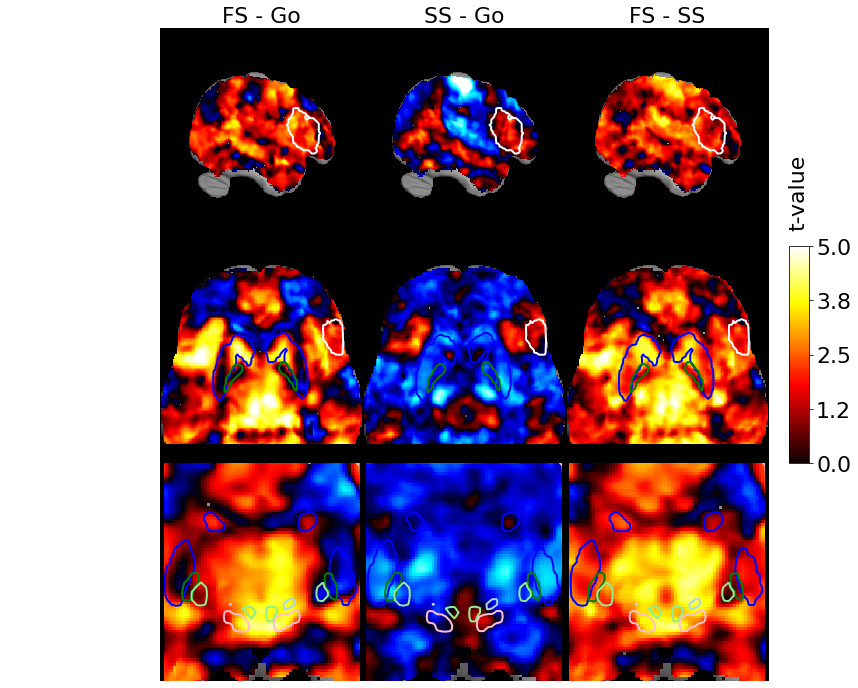

In [52]:
# plot t maps for smoothed images
fontsize = 22
vmax = 5
import matplotlib
font = {'family' : 'normal',
        'weight': 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)
matplotlib.rc('axes', titlesize=fontsize)

from matplotlib import gridspec
gridspec_kws = dict(hspace=0.0, wspace=0.0, 
                width_ratios=[1] * len(zmaps) + [.1, .1, .1])
gs = gridspec.GridSpec(3, len(zmaps)+3, **gridspec_kws)
f, axes = plt.subplots(3, len(zmaps)+3, gridspec_kw=gridspec_kws)  
# add 5 columns: 3 interspaces, 2 colorbars

f, axes, disps = plot_spm(zmaps, 
                          roi_dict=get_roi_dict(),
                          z_threshold=0.001,
                          f=f, axes=axes,
                          roi_to_plot=['rIFG', 'STR', 'STN'],
                          cut_coords=[[51], [2], [-13]],
                          bg_img=mni09c,
                          vmax=vmax, #colorbar=False, 
                          plot_columns=(0, 1, 2, 3, 4),
                          annotate=False, empty_plots=False, 
                          skip_all_but_last=False)
axes[0,0].set_title('FS - Go')
axes[0,1].set_title('SS - Go')
axes[0,2].set_title('FS - SS')
#axes[0,3].set_title('20')

for row in range(axes.shape[0]):
#     axes[row,2].set_visible(False)
#     axes[row,5].set_visible(False)
#     axes[row,8].set_visible(False)
    if row in [0,1,2]:
        for col in [-3,-2,-1]:
            axes[row,col].set_visible(False)
            axes[row,col].set_visible(False)

# Adjust positions of y labels
axes[0,0].set_ylabel('x = 51', labelpad=-24)
axes[1,0].set_ylabel('y = 2', labelpad=-24)
axes[2,0].set_ylabel('z = -13', labelpad=-24)

# colormap legend
cbar_ax1 = f.add_subplot(gs[1,-2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=cbar_ax1, vmin=0,
                                vmax=vmax, truncation_limits=(0,vmax), offset=0, flip=False, nb_ticks=5, format="%.1f")
cbar_ax1.yaxis.set_ticks_position('right')
cbar_ax1.set_title('t-value', rotation=90, ha='center', va='bottom', pad=16)

# Check stuff
### rIFG pretty low z values? why? Check individual mean t values and check variance

In [70]:
# # fsgo_intercept = nib.load('../derivatives/glm_feat/group_level_models/ses-sstmsit/task-sst/fwhm-1p5/model-0/firstlevelcontrast-SPD-ACC_secondlevelcontrast-intercept.nii.gz')
#fsgo_intercept = nib.load('../derivatives/glm_feat/group_level_model/ses-sstmsit/task-sst/third_level_model/level3_copes/_contrast_n_3_fwhm_1p5_model_n_0/cope1.nii.gz')
fsgo_intercept_thresh, thresh = nilearn.glm.threshold_stats_img(stat_img=zmap_fsgo, height_control='fdr', alpha=0.05)


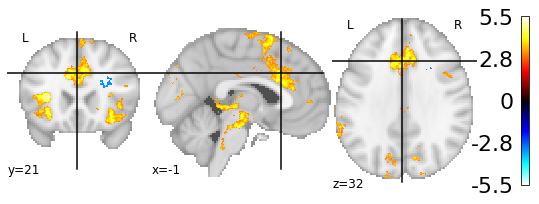

In [72]:
plotting.plot_stat_map(fsgo_intercept_thresh)

In [73]:
from nilearn import image
from nilearn.regions import connected_regions

regions_percentile_img, index = connected_regions(fsgo_intercept_thresh,
                                                  min_region_size=100)

/home/scotti/.conda/envs/py38/lib/python3.8/site-packages/nilearn/plotting/displays.py:607: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure = plt.figure(figure, figsize=figsize,
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


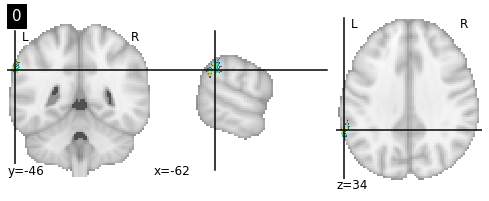

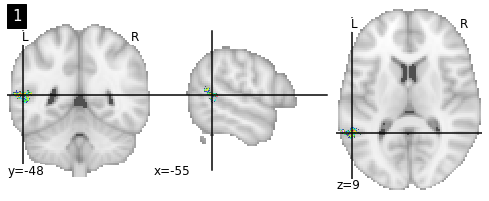

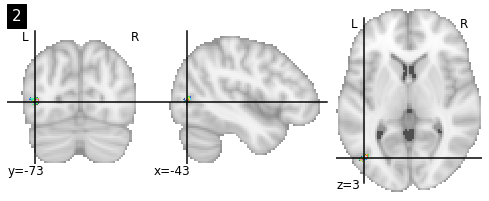

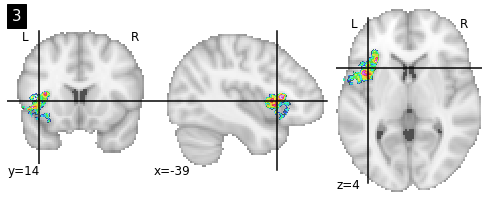

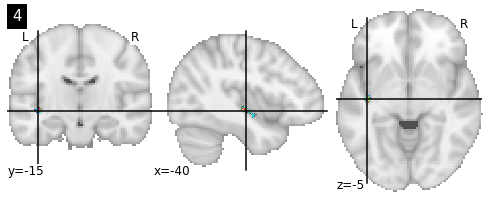

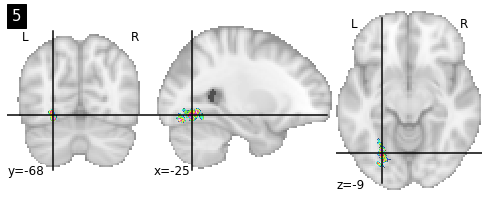

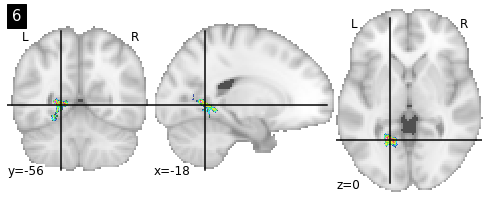

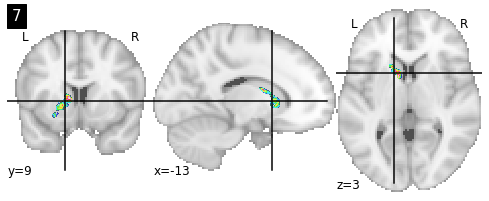

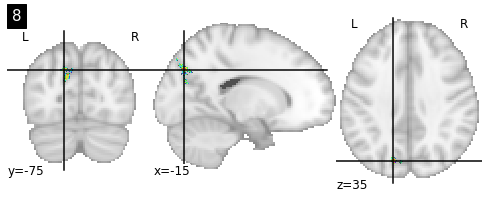

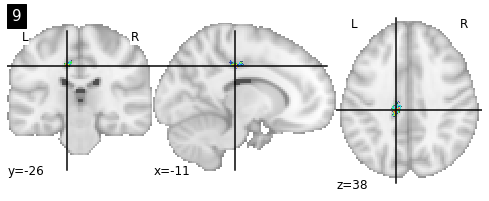

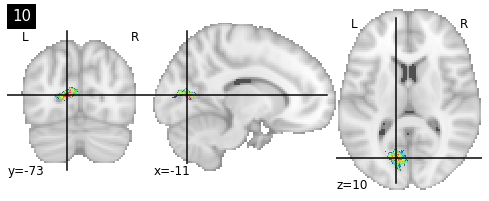

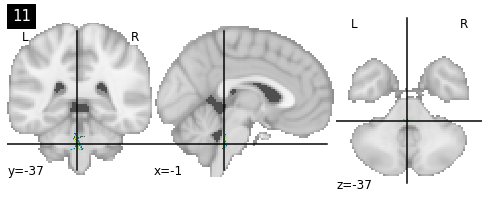

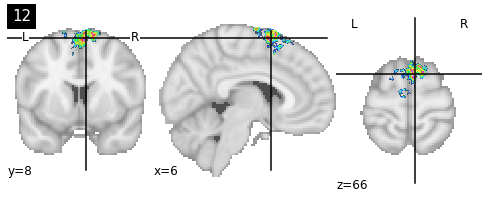

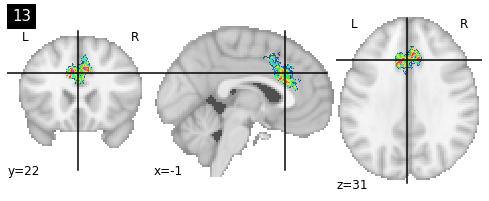

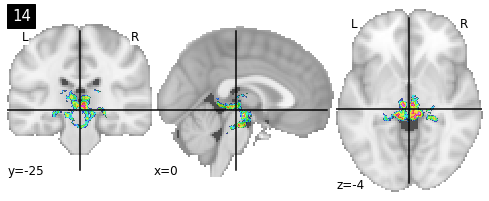

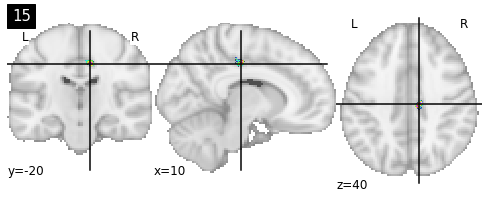

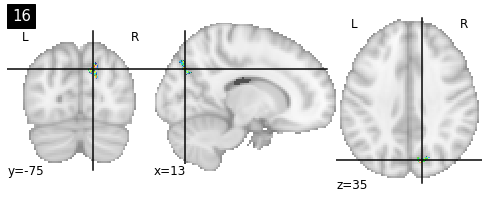

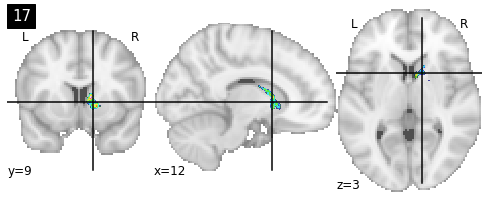

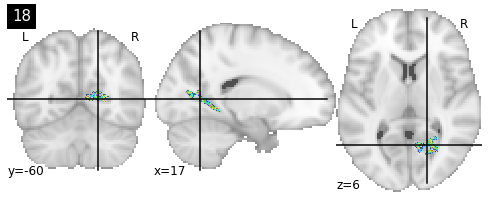

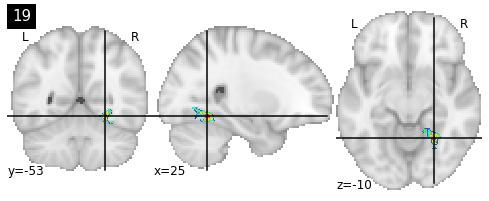

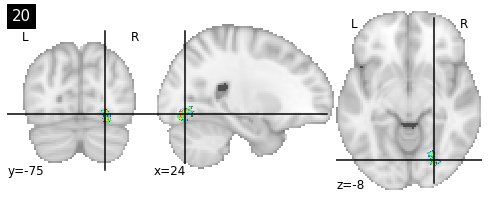

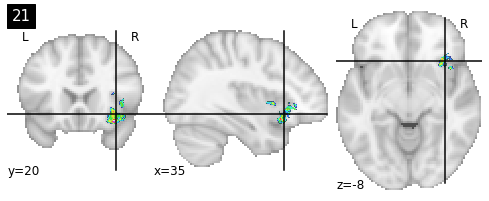

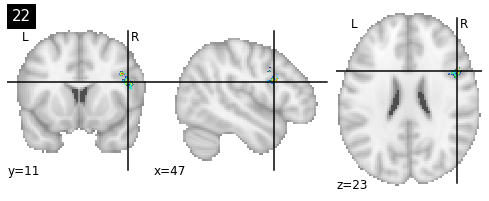

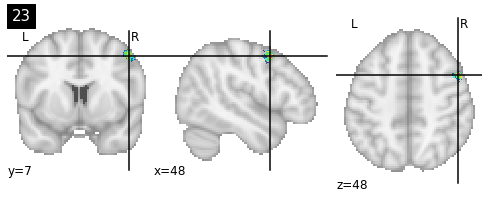

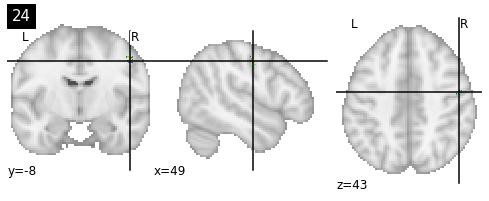

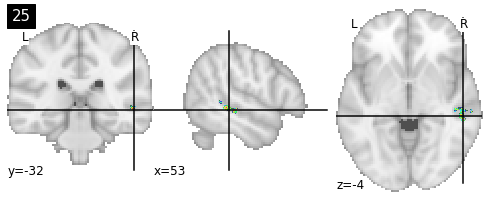

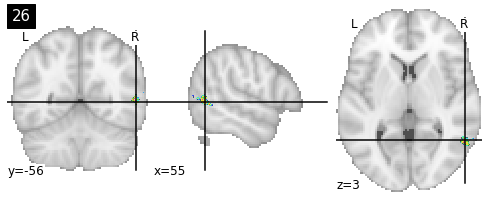

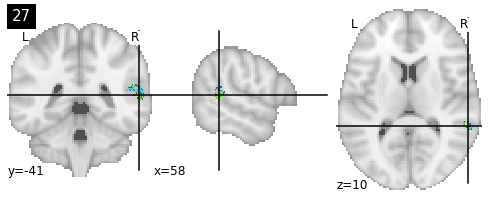

In [74]:
for i in range(regions_percentile_img.shape[-1]):
    plotting.plot_roi(image.index_img(regions_percentile_img, i), title=i) 

In [75]:
str_l = image.index_img(regions_percentile_img,7)
str_r = image.index_img(regions_percentile_img,17)

midbrain = image.index_img(regions_percentile_img,14)
presma = image.index_img(regions_percentile_img,12)

rifg = image.index_img(regions_percentile_img,22)

In [91]:
all_t = sorted(glob.glob('../derivatives/glm_feat/subject_level_model/sub-0*/ses-sstmsit/func/fwhm-1p5/model-0/sub-*_ses-sstmsit_task-sst_space-MNI152NLin2009cAsym_model-*_contrast-3_desc-zstat.nii.gz'))
all_t

['../derivatives/glm_feat/subject_level_model/sub-002/ses-sstmsit/func/fwhm-1p5/model-0/sub-002_ses-sstmsit_task-sst_space-MNI152NLin2009cAsym_model-0_contrast-3_desc-zstat.nii.gz',
 '../derivatives/glm_feat/subject_level_model/sub-003/ses-sstmsit/func/fwhm-1p5/model-0/sub-003_ses-sstmsit_task-sst_space-MNI152NLin2009cAsym_model-0_contrast-3_desc-zstat.nii.gz',
 '../derivatives/glm_feat/subject_level_model/sub-004/ses-sstmsit/func/fwhm-1p5/model-0/sub-004_ses-sstmsit_task-sst_space-MNI152NLin2009cAsym_model-0_contrast-3_desc-zstat.nii.gz',
 '../derivatives/glm_feat/subject_level_model/sub-005/ses-sstmsit/func/fwhm-1p5/model-0/sub-005_ses-sstmsit_task-sst_space-MNI152NLin2009cAsym_model-0_contrast-3_desc-zstat.nii.gz',
 '../derivatives/glm_feat/subject_level_model/sub-006/ses-sstmsit/func/fwhm-1p5/model-0/sub-006_ses-sstmsit_task-sst_space-MNI152NLin2009cAsym_model-0_contrast-3_desc-zstat.nii.gz',
 '../derivatives/glm_feat/subject_level_model/sub-007/ses-sstmsit/func/fwhm-1p5/model-0/su

In [92]:
regex = re.compile('.*/sub-(?P<sub>\d+)_ses-sstmsit_task-sst.*.nii.gz')
# regex.match(all_spms[0]).groupdict()['sub']

In [93]:
all_betas = []
for fn in all_t:
    sub = regex.match(fn).groupdict()['sub']
    data = nib.load(fn).get_fdata()
    this_sub = pd.DataFrame({'sub': sub, 
                             'str_l': data[str_l.get_fdata()>0].mean(),
                             'str_r': data[str_r.get_fdata()>0].mean(),
                             'midbrain': data[midbrain.get_fdata()>0].mean(),
                             'presma': data[presma.get_fdata()>0].mean(),
                             'rifg': data[presma.get_fdata()>0].mean()
                             }, index=[0])
    
    all_betas.append(this_sub)
all_betas = pd.concat(all_betas)

In [94]:
all_betas

sub     str_l     str_r  midbrain    presma      rifg
0  002 -0.135638 -0.007755  0.248994  0.176702  0.176702
0  003  1.898287  1.815820  1.703089  1.556383  1.556383
0  004  1.372152  1.834288  1.306663  1.449542  1.449542
0  005  1.086033  1.522121  0.845346  2.011748  2.011748
0  006  0.432812  0.377184  1.142013  0.948326  0.948326
0  007  1.317681  1.359676  1.388697  1.320832  1.320832
0  008  0.987629  0.744452  1.483900  0.691559  0.691559
0  009  2.372233  2.361772  1.847294  1.680765  1.680765
0  010  2.632913  2.473324  1.891694  1.856767  1.856767
0  011  0.885784  0.912896  0.854946  0.944587  0.944587
0  012  1.005062  0.985402  0.345106  1.204496  1.204496
0  013  1.097418  0.557678  0.747526  1.020184  1.020184
0  015  2.005121  1.820642  1.821413  1.551817  1.551817
0  016  0.421530  0.325040  0.491425  0.611939  0.611939
0  017  0.715270  0.618802  1.301537  0.463705  0.463705
0  018  0.195946  0.336493  0.341643  0.839663  0.839663
0  019  2.316137  2.473976  1.046171  2.174051  2.174051
0  020 -0.055712  0.210391  0.327214  0.299756  0.299756
0  023  1.309800  0.512786  0.733097  0.677242  0.677242
0  024  1.381017  1.863331  1.321709  1.582223  1.582223
0  026  1.030773  1.136554  0.617113  0.915132  0.915132

In [79]:
all_betas

sub        str_l        str_r     midbrain       presma         rifg
0  002  -213.308488    19.248321   585.995514   206.933054   206.933054
0  003  3658.873322  3249.550516  3311.552661  3320.402628  3320.402628
0  004  2952.466121  2979.698042  2330.251868  2641.705998  2641.705998
0  005  1810.866309  2223.192545  1284.577744  3755.630556  3755.630556
0  006   528.854949   373.059399  1507.631022  1590.623623  1590.623623
0  007  2274.410236  2080.608548  2405.968516  2195.190237  2195.190237
0  008  1675.756730  1174.061037  2265.239528  1160.160351  1160.160351
0  009  4383.709490  4014.022976  3278.880066  2691.365552  2691.365552
0  010  5075.581144  4242.637374  3347.006400  4022.225561  4022.225561
0  011  1715.175455  1454.491988  1840.940796  1965.015056  1965.015056
0  012  1921.583981  1699.818817   613.396125  2064.153297  2064.153297
0  013  2223.218372  1107.316028  1730.715693  1939.393613  1939.393613
0  015  3399.093880  3174.019112  2779.839548  2566.308858  2566.308858
0  016   643.769068   445.036850   737.954013  1110.935746  1110.935746
0  017  1276.612009  1092.494618  2594.373830   926.755582   926.755582
0  018   495.074056   655.092148   793.587557  1715.969108  1715.969108
0  019  7071.658926  6499.695259  3112.735252  7500.629296  7500.629296
0  020   -96.321765   378.876436   635.421993   595.540049   595.540049
0  023  2070.379961   724.151083  1079.601741   994.046348   994.046348
0  024  4070.239628  4880.549720  3379.148190  4928.149096  4928.149096
0  026  1585.504809  1741.855854   972.665683  1485.148955  1485.148955

In [89]:
np.mean(all_betas.rifg)

2351.2515506378536

In [88]:
np.std(all_betas.rifg)

1629.6834465886911

In [84]:
all_betas.rifg

0     206.933054
0    3320.402628
0    2641.705998
0    3755.630556
0    1590.623623
0    2195.190237
0    1160.160351
0    2691.365552
0    4022.225561
0    1965.015056
0    2064.153297
0    1939.393613
0    2566.308858
0    1110.935746
0     926.755582
0    1715.969108
0    7500.629296
0     595.540049
0     994.046348
0    4928.149096
0    1485.148955
Name: rifg, dtype: float64

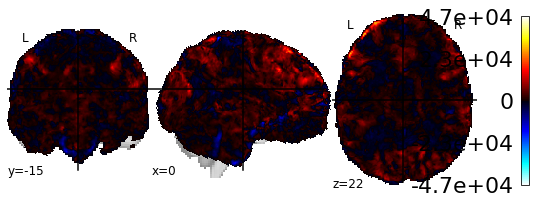

In [90]:
plotting.plot_stat_map('../derivatives/glm_feat/subject_level_model/sub-010/ses-sstmsit/func/fwhm-1p5/model-0/sub-010_ses-sstmsit_task-sst_space-MNI152NLin2009cAsym_model-0_contrast-3_desc-cope.nii.gz')

In [27]:
import glob
import re

def build_coordinate_mapping(source_image, target_image, h5_forward, h5_inverse, output_dir='./', file_name=None,
                             verbose=False, save_data=True):
    from nipype.interfaces.ants import ApplyTransforms
    import nibabel as nb
    from nighres.io import load_volume, save_volume
    from nighres.utils import _output_dir_4saving, _fname_4saving, _check_topology_lut_dir

    X=0
    Y=1
    Z=2
    T=3
    
    # load
    if verbose:
        print('Loading source & target...')
    source = load_volume(source_image)
    src_affine = source.affine
    src_header = source.header
    nsx = source.header.get_data_shape()[X]
    nsy = source.header.get_data_shape()[Y]
    nsz = source.header.get_data_shape()[Z]
    rsx = source.header.get_zooms()[X]
    rsy = source.header.get_zooms()[Y]
    rsz = source.header.get_zooms()[Z]

    target = load_volume(target_image)
    trg_affine = target.affine
    trg_header = target.header
    ntx = target.header.get_data_shape()[X]
    nty = target.header.get_data_shape()[Y]
    ntz = target.header.get_data_shape()[Z]
    rtx = target.header.get_zooms()[X]
    rty = target.header.get_zooms()[Y]
    rtz = target.header.get_zooms()[Z]
    
    if verbose:
        print('Building coordinate mappings...')
    # build coordinate mappings
    src_coord = np.zeros((nsx,nsy,nsz,3))
    trg_coord = np.zeros((ntx,nty,ntz,3))
    for x in range(nsx):
        for y in range(nsy):
            for z in range(nsz):
                src_coord[x,y,z,X] = x
                src_coord[x,y,z,Y] = y
                src_coord[x,y,z,Z] = z
    src_map = nb.Nifti1Image(src_coord, source.affine, source.header)
    src_map_file = os.path.join(output_dir, _fname_4saving(file_name=file_name,
                                                           rootfile=source_image,
                                                           suffix='tmp_srccoord'))
    save_volume(src_map_file, src_map)
    for x in range(ntx):
        for y in range(nty):
            for z in range(ntz):
                trg_coord[x,y,z,X] = x
                trg_coord[x,y,z,Y] = y
                trg_coord[x,y,z,Z] = z
    trg_map = nb.Nifti1Image(trg_coord, target.affine, target.header)
    trg_map_file = os.path.join(output_dir, _fname_4saving(file_name=file_name,
                                                           rootfile=source_image,
                                                           suffix='tmp_trgcoord'))
    save_volume(trg_map_file, trg_map)
    
#     if verbose:
#         print('Applying transforms to source...')
#     at = ApplyTransforms()
#     at.inputs.dimension = 2
#     at.inputs.input_image = source.get_filename()
#     at.inputs.reference_image = target.get_filename()
#     at.inputs.interpolation = 'NearestNeighbor'
#     at.inputs.transforms = h5_forward
# #    at.inputs.invert_transform_flags = result.outputs.forward_invert_flags
#     print(at.cmdline)
#     transformed = at.run()

    if verbose:
        print('Applying transforms to forward...')
    # Create coordinate mappings
    src_at = ApplyTransforms()
    src_at.inputs.dimension = 3
    src_at.inputs.input_image_type = 3
    src_at.inputs.input_image = src_map.get_filename()
    src_at.inputs.reference_image = target.get_filename()
    src_at.inputs.interpolation = 'Linear'
    src_at.inputs.transforms = h5_forward
#    src_at.inputs.invert_transform_flags = result.outputs.forward_invert_flags
    mapping = src_at.run()

    if verbose:
        print('Applying transforms to inverse...')
    trg_at = ApplyTransforms()
    trg_at.inputs.dimension = 3
    trg_at.inputs.input_image_type = 3
    trg_at.inputs.input_image = trg_map.get_filename()
    trg_at.inputs.reference_image = source.get_filename()
    trg_at.inputs.interpolation = 'Linear'
    trg_at.inputs.transforms = h5_inverse
#    trg_at.inputs.invert_transform_flags = result.outputs.reverse_invert_flags
    inverse = trg_at.run()
    
    # save - already done?
    if verbose:
        print('Creating niftis...')
    mapping_img = nb.Nifti1Image(nb.load(mapping.outputs.output_image).get_data(),
                                    target.affine, target.header)
    inverse_img = nb.Nifti1Image(nb.load(inverse.outputs.output_image).get_data(),
                                    source.affine, source.header)

    outputs = {'mapping': mapping_img,
               'inverse': inverse_img}

    if verbose:
        print('Clean-up & save...')
    # clean-up intermediate files
    os.remove(src_map_file)
    os.remove(trg_map_file)

    os.remove(mapping.outputs.output_image)
    os.remove(inverse.outputs.output_image)

    if save_data:
        mapping_file = os.path.join(output_dir,
                                    _fname_4saving(file_name=file_name,
                                               rootfile=source_image,
                                               suffix='ants-map'))

        inverse_mapping_file = os.path.join(output_dir,
                                            _fname_4saving(file_name=file_name,
                                                    rootfile=source_image,
                                                    suffix='ants-invmap'))
#         save_volume(transformed_source_file, transformed_img)
        save_volume(mapping_file, mapping_img)
        save_volume(inverse_mapping_file, inverse_img)
        
    return outputs

def load_atlas(resolution='1p6mm'):
    ### Rois in MNI09c-space
    mask_dir='./masks/final_masks_mni09c_' + resolution
    fns = glob.glob(mask_dir + '/space-*')
    fns.sort()
    names = [re.match('.*space-(?P<space>[a-zA-Z0-9]+)_label-(?P<label>[a-zA-Z0-9]+)_probseg.nii.gz', fn).groupdict()['label'] for fn in fns]
    roi_dict = dict(zip(names, fns))
    
    from nilearn import image
    combined = image.concat_imgs(roi_dict.values())
    
    class AttrDict(dict):
        def __init__(self, *args, **kwargs):
            super(AttrDict, self).__init__(*args, **kwargs)
            self.__dict__ = self
            
    roi_atlas = AttrDict({'maps': combined,
                          'labels': roi_dict.keys()})
    
    return roi_atlas


# functions for combining echos, based on the tedana workflow
def combine_tedana(tes, data, combmodes=('t2s', 'ste'), mask=None, overwrite=True):
    """ Function based on tedana main workflow """
    from tedana import utils, model, io, decay, combine
    from scipy import stats
    import numpy as np
    import os
    
    # ensure tes are in appropriate format
    tes = [float(te) for te in tes]
    n_echos = len(tes)

    # coerce data to samples x echos x time array
    if isinstance(data, str):
        data = [data]

    catd, ref_img = io.load_data(data, n_echos=n_echos)
    n_samp, n_echos, n_vols = catd.shape
    
    mask, masksum = utils.make_adaptive_mask(catd, mask=mask, minimum=False, getsum=True)

    # check if the t2s-map is already created first
    base_name = data[0].replace('_echo-1', '').replace('desc-preproc-hp', 'desc-preproc-hp-%s').replace('.nii', '').replace('.gz', '')    
    
    if not os.path.exists(base_name %'t2sv' + '.nii.gz') or overwrite:
        t2s, s0, t2ss, s0s, t2sG, s0G = decay.fit_decay(catd, tes, mask, masksum)
        # set a hard cap for the T2* map
        # anything that is 10x higher than the 99.5 %ile will be reset to 99.5 %ile
        cap_t2s = stats.scoreatpercentile(t2s.flatten(), 99.5,
                                          interpolation_method='lower')
        t2s[t2s > cap_t2s * 10] = cap_t2s
        
        # save
        io.filewrite(t2s, base_name %'t2sv' + '.nii', ref_img, gzip=True)
        io.filewrite(s0, base_name %'s0v' + '.nii', ref_img, gzip=True)
        io.filewrite(t2ss, base_name %'t2ss' + '.nii', ref_img, gzip=True)
        io.filewrite(s0s, base_name %'s0vs' + '.nii', ref_img, gzip=True)
        io.filewrite(t2sG, base_name %'t2svG' + '.nii', ref_img, gzip=True)
        io.filewrite(s0G, base_name %'s0vG' + '.nii', ref_img, gzip=True)
        
    else:
        t2sG = utils.load_image(base_name %'t2svG' + '.nii.gz')
        t2s = utils.load_image(base_name %'t2sv' + '.nii.gz')
        
    # optimally combine data
    if 't2s' in combmodes:
        print('Combining echos using optcomb...', end='')
        ext = 'optcomb'
        data_oc = combine.make_optcom(catd, tes, mask, t2s=t2sG, combmode='t2s')
        # make sure to set all nan-values/inf to 0
        data_oc[np.isinf(data_oc)] = 0
        data_oc[np.isnan(data_oc)] = 0
        print('Done, writing results...')
        io.filewrite(data_oc, base_name %ext + '.nii', ref_img, gzip=True)
    if 'ste' in combmodes:
        print('Combining echos using optcomb...', end='')
        ext = 'PAID'
        data_oc = combine.make_optcom(catd, tes, mask, t2s=t2sG, combmode='ste')
        # make sure to set all nan-values/inf to 0
        data_oc[np.isinf(data_oc)] = 0
        data_oc[np.isnan(data_oc)] = 0
        io.filewrite(data_oc, base_name %ext + '.nii', ref_img, gzip=True)
        print('Done, writing results...')
        
    return 0

# create tsnr
import nibabel as nib
import numpy as np
def tsnr_img(hdr):
    if isinstance(hdr, str):
        hdr = nib.load(hdr)
        
    dat = hdr.get_data()
    mn = np.mean(dat, 3)
    sd = np.std(dat, 3)
    
    img = nib.Nifti1Image(mn/sd, hdr.affine)
    return img



###### Supplementary plotting functions
def get_color(mask):
    if 'STN' in mask:
        return 'lightblue'
    if 'STR' in mask:
        return 'blue'
    if 'PreSMA' in mask:
        return 'darkgreen'
    if 'ACC' in mask:
        return 'green'
    if 'M1' in mask:
        return 'pink'
    if 'GPi' in mask:
        return 'lightgreen'
    if 'GPe' in mask:
        return 'green'
    if 'IFG' in mask:
        return 'white'
    if 'VTA' in mask:
        return 'lightgreen'
    if 'SN' in mask:
        return 'pink'

def get_roi_dict():
    # make dict of masks & filenames in 09c-space, get colors
    fns = glob.glob('./masks/final_masks_mni09c_1mm/space*')
    fns.sort()
    names = [re.match('.*space-(?P<space>[a-zA-Z0-9]+)_label-(?P<label>[a-zA-Z0-9]+)_probseg.nii.gz', fn).groupdict()['label'] for fn in fns]
    roi_dict = dict(zip(names, fns))
    for mask, fn in roi_dict.items():
        roi_dict[mask] = {}
        roi_dict[mask]['fn'] = fn
        roi_dict[mask]['color'] = get_color(mask)
        roi_dict[mask]['threshold'] = 0.3
    return roi_dict

def get_prop_limits(props, current_limits):
    extent = current_limits[1]-current_limits[0]
    x0 = current_limits[0] + extent*props[0]
    x1 = current_limits[0] + extent*props[1]
    return (x0, x1)

def add_contours(disp, roi, color='white', linewidth=2, thr=0.3, **kwargs):
    from nilearn._utils.extmath import fast_abs_percentile
    from nilearn._utils.param_validation import check_threshold
    if not isinstance(roi, nib.Nifti1Image):
        map_img = nib.load(roi)
    else:
        map_img = roi
    data = map_img.get_data()
    
    # manually threhsold image
    data[data < thr] = 0
    
    # then determine the plotting threshold - this is a different value, required for plotting reasons,
    # and finds the percentile of the data that corresponds to the threshold
#     thr = check_threshold(thr, data,
#                           percentile_func=fast_abs_percentile,
#                           name='threshold')
    
    # Get rid of background values in all cases
    thr = max(thr, 1e-6)
    disp.add_contours(nib.Nifti1Image(data, map_img.affine), levels=[thr], linewidths=linewidth, colors=[color], **kwargs)

from nilearn import plotting
def draw_custom_colorbar(colorbar_ax, vmin=3, vmax=6, truncation_limits=(0,6), offset=4., nb_ticks=4, flip=True,
                         format="%d", cmap=plotting.cm.cold_hot):
    from matplotlib.colorbar import ColorbarBase
    from matplotlib import colors
    our_cmap = cmap
    if flip:
        truncation_limits = [truncation_limits[1], truncation_limits[0]]
    ticks = np.linspace(truncation_limits[0], truncation_limits[1], nb_ticks)
    bounds = np.linspace(truncation_limits[0], truncation_limits[1], our_cmap.N)
    norm = colors.Normalize(vmin=-vmax, vmax=vmax)
    
    # some colormap hacking
    cmaplist = [our_cmap(i) for i in range(our_cmap.N)]
    istart = int(norm(-offset, clip=True) * (our_cmap.N - 1))
    istop = int(norm(offset, clip=True) * (our_cmap.N - 1))
    for i in range(istart, istop):
        cmaplist[i] = (0.5, 0.5, 0.5, 1.)  # just an average gray color
    our_cmap = our_cmap.from_list('Custom cmap', cmaplist, our_cmap.N)

    ColorbarBase(colorbar_ax, ticks=ticks, norm=norm,
                 orientation='vertical', cmap=our_cmap, boundaries=bounds,
                 spacing='proportional', format=format)
    
    if flip:
        colorbar_ax.invert_yaxis()
        colorbar_ax.yaxis.tick_right()
    else:
        colorbar_ax.yaxis.tick_left()

#     tick_color = 'w'
#     for tick in colorbar_ax.yaxis.get_ticklabels():
#         tick.set_color(tick_color)
#     colorbar_ax.yaxis.set_tick_params(width=0)
    return colorbar_ax

    

########## Plotting functions
from nilearn import plotting
from matplotlib import gridspec
import matplotlib.pyplot as plt

def plot_spm(zmaps, roi_dict, bg_img=None, z_threshold=0, f=None, axes=None,
             # brain_mask='../Templates/mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c.nii.gz',
             roi_to_plot=('PreSMA', 'M1', 'ACC', 'rIFG', 'STR', 'GPe', 'GPi', 'STN'),
             cut_coords=[None, None, None, None, None, None, None, None],
             contrasts=('failed_stop - go_trial',
                        'successful_stop - go_trial',
                        'failed_stop - successful_stop'),
             plot_columns=(0, 1, 3, 4, 6, 7),
             empty_plots=False, skip_all_but_last=False,
             **kwargs):
    
    if f is None:
        gridspec = dict(hspace=0.0, wspace=0.0, width_ratios=[1, 1, 0.05, 1, 1, .05, 1, 1, .1])
        f, axes = plt.subplots(len(roi_to_plot), len(zmaps)+3, gridspec_kw=gridspec)  # add 3 columns: 2 interspace, 1 on the right for the colorbar
 
    if empty_plots:
        f.set_size_inches(len(zmaps)*4, len(roi_to_plot)*4)
        return f, axes
    
    all_cut_coords = []
    all_disps = []
    for row_n, roi in enumerate(roi_to_plot):
        # for debugging
        if skip_all_but_last:
            if row_n < (len(roi_to_plot)-1):
                continue
        
        # get cut coordinates based on 1 hemisphere (if applicable)
        if roi in ['STR', 'STN', 'PreSMA', 'GPe', 'GPi']:
            roi_map = roi_dict['l' + roi]
        else:
            roi_map = roi_dict[roi]
#        roi_map = make_conjunction_mask(roi_map['fn'], brain_mask)
        if roi == 'rIFG':
            ## saggital
            if cut_coords[row_n] is None:
                this_cut_coords = plotting.find_xyz_cut_coords(roi_map['fn'])[0:1]
            else:
                this_cut_coords = cut_coords[row_n]
            display_mode='x'
            plot_rois = ['rIFG']#, 'M1', 'rPreSMA']
        elif roi == 'STR':
            ## axial view
            if cut_coords[row_n] is None:
                this_cut_coords = plotting.find_xyz_cut_coords(roi_map['fn'])[2:3]
            else:
                this_cut_coords = cut_coords[row_n]

            display_mode='z'
            plot_rois = ['rIFG', 'M1',
                         'lSTR', 'lGPe', 'lGPi', 'lSTN', 'lVTA', 'lSN',
                         'rSTR', 'rGPe', 'rGPi', 'rSTN', 'rVTA', 'rSN']
        elif roi == 'STN':
            ## plot coronal view
            if cut_coords[row_n] is None:
                this_cut_coords = plotting.find_xyz_cut_coords(roi_map['fn'])[1:2]
            else:
                this_cut_coords = cut_coords[row_n]

            display_mode='y'
            plot_rois = ['rIFG', 'M1',
                         'lSTR', 'lGPe', 'lGPi', 'lSTN', 'lVTA', 'lSN',
                         'rSTR', 'rGPe', 'rGPi', 'rSTN', 'rVTA', 'rSN']

        all_cut_coords.append({display_mode: this_cut_coords[0]})
        
        # loop over contrasts for columns
        for col_n, map_n in zip(plot_columns, np.arange(len(zmaps))):
            zmap = zmaps[map_n]
            if skip_all_but_last:
                if col_n < (len(zmaps)-1):
                    continue
            
            if row_n == (len(roi_to_plot)-1) and col_n == (len(zmaps)-1):
                # plot colobar in the last plot
                cbar = False
            else:
                cbar = False
            
#             # do not plot in column 2 or 5
#             plot_col = col_n
#             if col_n > 1:
#                 plot_col = col_n + 1
#             if col_n > 3:
#                 plot_col = col_n + 2
                
            if isinstance(z_threshold, list):
                this_threshold = z_threshold[map_n]
            else:
                this_threshold = z_threshold
            ax = axes[row_n, col_n]
            
#             print(cbar)
            disp = plotting.plot_stat_map(zmap, bg_img=bg_img, 
                                          threshold=this_threshold, cut_coords=this_cut_coords,
                                          display_mode=display_mode, axes=ax, colorbar=cbar, **kwargs)
        
            # just plot *all* contours, always
            for roi_ in plot_rois:
                roi_map = roi_dict[roi_]
#             for roi_, roi_map in roi_dict.items():
#                 print(roi_map)
                add_contours(disp, roi=roi_map['fn'], thr=roi_map['threshold'], color=roi_map['color'])

            # determine limits (xlim/ylim) based on first column, and apply to all others
            this_key = list([x for x in disp.axes.keys()])[0]
            # Determine new xlim/ylim based on first column
            if col_n == plot_columns[0]:
                # extract old/current limits
                cur_xlim = disp.axes[this_key].ax.get_xlim()
                cur_ylim = disp.axes[this_key].ax.get_ylim()
                if display_mode == 'x':
                    new_xlim = get_prop_limits([0, 1], cur_xlim)
                    new_ylim = get_prop_limits([0, 1], cur_ylim)
                elif display_mode == 'z' and 'STN' in roi:            
                    new_xlim = get_prop_limits([.25, .75], cur_xlim)
                    new_ylim = get_prop_limits([.40, .90], cur_ylim)
                elif display_mode == 'z' and 'STR' in roi:
                    new_xlim = get_prop_limits([0, 1], cur_xlim)
                    new_ylim = get_prop_limits([0.3, 1], cur_ylim)
                elif display_mode == 'y':
                    new_xlim = get_prop_limits([.26, .74], cur_xlim)
                    new_ylim = get_prop_limits([.25, .75], cur_ylim)

            # Change axes limits
            disp.axes[this_key].ax.set_xlim(new_xlim[0], new_xlim[1])
            disp.axes[this_key].ax.set_ylim(new_ylim[0], new_ylim[1])
            
            all_disps.append(disp)

#             # set new xlimits if necessary (ie zoom for STN view)
#             if 'STN' in roi and display_mode == 'z':
#                 this_key = [x for x in disp.axes.keys()]
#                 this_key = this_key[0]
#                 cur_xlim = disp.axes[this_key].ax.get_xlim()
#                 cur_ylim = disp.axes[this_key].ax.get_ylim()
#                 new_xlim = get_prop_limits([.25, .75], cur_xlim)
#                 new_ylim = get_prop_limits([.40, .90], cur_ylim)
#                 disp.axes[this_key].ax.set_xlim(new_xlim[0], new_xlim[1])
#                 disp.axes[this_key].ax.set_ylim(new_ylim[0], new_ylim[1])
#             elif 'STN' in roi and display_mode == 'y':
#                 this_key = [x for x in disp.axes.keys()]
#                 this_key = this_key[0]
#                 cur_xlim = disp.axes[this_key].ax.get_xlim()
#                 cur_ylim = disp.axes[this_key].ax.get_ylim()
#                 new_xlim = get_prop_limits([.25, .75], cur_xlim)
#                 new_ylim = get_prop_limits([.25, .75], cur_ylim)
#                 disp.axes[this_key].ax.set_xlim(new_xlim[0], new_xlim[1])
#                 disp.axes[this_key].ax.set_ylim(new_ylim[0], new_ylim[1])
#             elif 'STR' in roi and display_mode == 'z':
#                 this_key = [x for x in disp.axes.keys()]
#                 this_key = this_key[0]
#                 cur_xlim = disp.axes[this_key].ax.get_xlim()
#                 cur_ylim = disp.axes[this_key].ax.get_ylim()
#                 new_xlim = get_prop_limits([0, 1], cur_xlim)
#                 new_ylim = get_prop_limits([.3, 1], cur_ylim)
#                 disp.axes[this_key].ax.set_xlim(new_xlim[0], new_xlim[1])
#                 disp.axes[this_key].ax.set_ylim(new_ylim[0], new_ylim[1])
                
#             all_disps.append(disp)
    
    # add labels
    if not skip_all_but_last:
        for row_n, ax in enumerate(axes[:,0]):
            cc = all_cut_coords[row_n]
            disp_mode = [x for x in cc.keys()][0]
            coord = cc[disp_mode]
            ax.annotate('%s = %d' %(disp_mode, int(coord)), 
                        xy=(0, 0.5), 
                        xytext=(-ax.yaxis.labelpad - 0.5, 0),
                        xycoords=ax.yaxis.label, 
                        textcoords='offset points', rotation=90, 
                        ha='right', va='center')

    f.set_size_inches(len(zmaps)*4, len(roi_to_plot)*4)
    
    return f, axes, all_disps



def plot_3x6(zmaps, thresholds, roi_dict=get_roi_dict(),
             titles=('Single echo', 'Multi echo (OC)', 'Single echo', 'Multi echo (OC)', 'Single echo', 'Multi echo (OC)'),
             contrast_names=('Contrast 1', 'Contrast 2', 'Contrast 3'),
             vmax=6, colorbars=((3, 6), (3, 6)),
             colorbar_title='z-values',
             **cb_kwargs):
    gridspec_kws = dict(hspace=0.0, wspace=0.0, 
                    width_ratios=[1, 1, 0.05, 1, 1, .05, 1, 1, .15, .1, .1])
    gs = gridspec.GridSpec(3, len(zmaps)+5, **gridspec_kws)
    f, axes = plt.subplots(3, len(zmaps)+5, gridspec_kw=gridspec_kws)
    # add 5 columns: 3 interspaces, 2 colorbars

    f, axes, disps = plot_spm(zmaps, roi_dict, z_threshold=thresholds,
                              f=f, axes=axes,
                              roi_to_plot=['rIFG', 'STR', 'STN'],
                              cut_coords=[[52], [2], [-13]],
                              bg_img='/home/stevenm/Templates/mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii',
                              vmax=vmax, #colorbar=False, 
                              annotate=False, empty_plots=False, 
                              skip_all_but_last=False)
    axes[0,0].set_title(titles[0])
    axes[0,1].set_title(titles[1])
    axes[0,3].set_title(titles[2])
    axes[0,4].set_title(titles[3])
    axes[0,6].set_title(titles[4])
    axes[0,7].set_title(titles[5])

    for row in range(axes.shape[0]):
        axes[row,2].set_visible(False)
        axes[row,5].set_visible(False)
        axes[row,8].set_visible(False)
        if row in [0,1,2]:
            for col in [-3,-2,-1]:
                axes[row,col].set_visible(False)
                axes[row,col].set_visible(False)

    # for titles: https://stackoverflow.com/questions/40936729/matplotlib-title-spanning-two-or-any-number-of-subplot-columns
    ext = []
    #loop over the columns (j) and rows(i) to populate subplots
    for j in range(8):
        # save the axes bounding boxes for later use
        ext.append([axes[0,j].get_window_extent().x0, axes[0,j].get_window_extent().width ])

    # make nice
    inv = f.transFigure.inverted()
    width_left = ext[0][0]+(ext[1][0]+ext[1][1]-ext[0][0])/2.
    left_center = inv.transform( (width_left, 1) )

    width_mid = ext[3][0]+(ext[4][0]+ext[4][1]-ext[3][0])/2.
    mid_center = inv.transform( (width_mid, 1) )

    width_right = ext[6][0]+(ext[7][0]+ext[7][1]-ext[6][0])/2.
    right_center = inv.transform( (width_right, 1) )

    # set column spanning title 
    # the first two arguments to figtext are x and y coordinates in the figure system (0 to 1)
    plt.figtext(left_center[0], .93, contrast_names[0], va="center", ha="center")
    plt.figtext(mid_center[0], .93, contrast_names[1], va="center", ha="center")
    plt.figtext(right_center[0], .93, contrast_names[2], va="center", ha="center")

    # Positions in MNI-space
    axes[0,0].set_ylabel('x = 51', labelpad=50)
    axes[1,0].set_ylabel('y = 2', labelpad=50)
    axes[2,0].set_ylabel('z = -13', labelpad=50)

    # colorbar
    thrs_ = thresholds
    if isinstance(thresholds, list):
        thrs_ = thresholds[0]
    
    cbar_ax1 = f.add_subplot(gs[1,-2])
    cbar_ax1 = draw_custom_colorbar(colorbar_ax=cbar_ax1, 
                                    vmin=colorbars[0][0], vmax=colorbars[0][1],
                                    truncation_limits=colorbars[0], offset=thrs_, flip=False, **cb_kwargs)
    
    if len(colorbars) == 2:
        cbar_ax2 = f.add_subplot(gs[1,-1])
        cbar_ax2 = draw_custom_colorbar(colorbar_ax=cbar_ax2, 
                                        vmin=colorbars[1][0], vmax=colorbars[1][1],
                                        truncation_limits=(-colorbars[1][0], -colorbars[1][1]), 
                                        offset=thrs_, flip=True, **cb_kwargs)
    
        cbar_ax1.set_title(colorbar_title, rotation=90, ha='center', va='bottom', pad=16, loc='right')    
    else:
        cbar_ax1.set_title(colorbar_title, rotation=90, ha='center', va='bottom', pad=16, loc='center')    
        
    return f, axes
    # f.savefig('./glm.pdf')#, bbox_inches='tight')

def barplot_annotate_brackets(num1, num2, data, center, height, yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None,
                             ax=None):
    """ 
    Annotate barplot with p-values.

    :param num1: number of left bar to put bracket over
    :param num2: number of right bar to put bracket over
    :param data: string to write or number for generating asterixes
    :param center: centers of all bars (like plt.bar() input)
    :param height: heights of all bars (like plt.bar() input)
    :param yerr: yerrs of all bars (like plt.bar() input)
    :param dh: height offset over bar / bar + yerr in axes coordinates (0 to 1)
    :param barh: bar height in axes coordinates (0 to 1)
    :param fs: font size
    :param maxasterix: maximum number of asterixes to write (for very small p-values)
    """
    
    if ax is None:
        ax = plt.gca()
    
    if type(data) is str:
        text = data
    else:
        # * is p < 0.05
        # ** is p < 0.01
        # *** is p < 0.001
        # etc.
        if 0.01 < data < 0.05:
            text = '*'
        elif 0.001 < data < 0.01:
            text = '**'
        elif data < 0.001:
            text = '***'
#         text = ''
#         p = .05

#         while data < p:
#             text += '*'
#             p /= 10.

#             if maxasterix and len(text) == maxasterix:
#                 break

#         if len(text) == 0:
#             text = 'n. s.'

    lx, ly = center[num1], height[num1]
    rx, ry = center[num2], height[num2]

    if yerr is not None:
        ly += yerr[num1]
        ry += yerr[num2]

    ax_y0, ax_y1 = ax.get_ylim()
    dh *= (ax_y1 - ax_y0)
    barh *= (ax_y1 - ax_y0)

    y = max(ly, ry) + dh

    barx = [lx, lx, rx, rx]
    bary = [y, y+barh, y+barh, y]
    mid = ((lx+rx)/2, y+barh)

    ax.plot(barx, bary, c='black')

    kwargs = dict(ha='center', va='bottom')
    if fs is not None:
        kwargs['fontsize'] = fs

    ax.text(*mid, text, **kwargs)
    


# ----- RANDOM CODE -------

In [ ]:
# plotting.plot_stat_map('../derivatives/glm_feat/group_level_model/ses-sstmsit/task-sst/third_level_model/level3_zstats/_contrast_n_3_fwhm_1p5_model_n_0/zstat1.nii.gz')